Take only users with Quick and SIL loans only disbursed from June 2024 and mature for FSPD30.
 
Total Number of customers all 4 segments combined should not exceed 80-100K

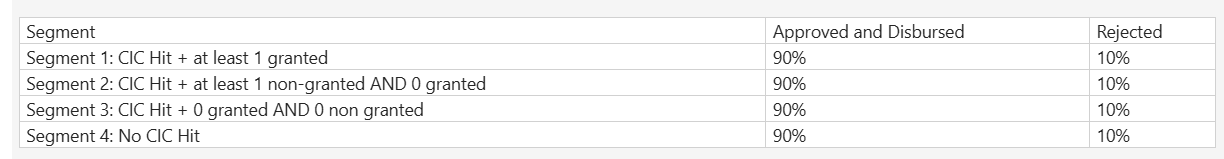

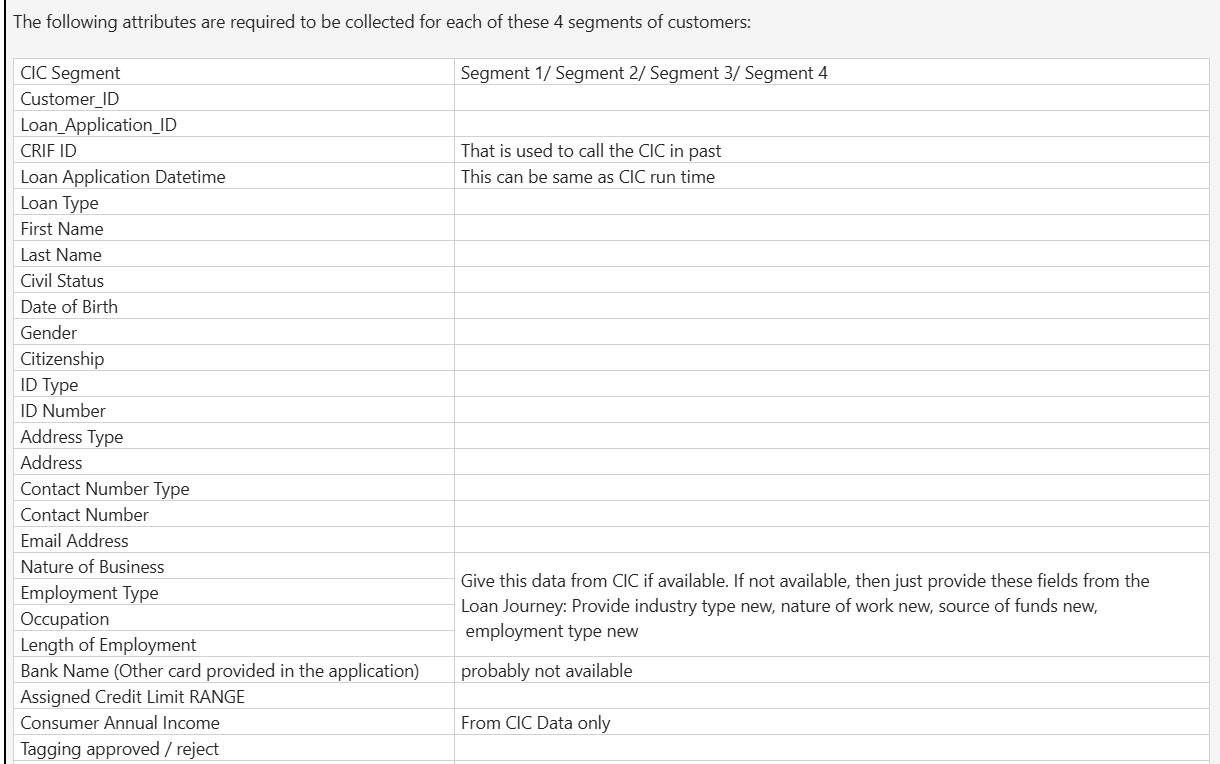

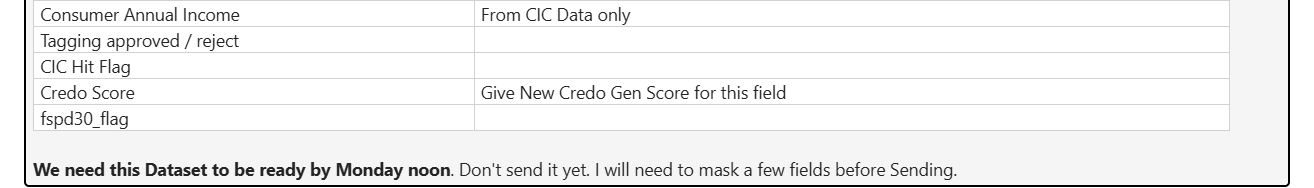

In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.
# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\Dwaipayan\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')
import time
# %% [markdown]
## Configure Settings
# Set options or configurations as needed

# Example: pd.set_option('display.max_columns', None)


In [2]:
# sq = """WITH
#   appliedloans AS (
#   SELECT
#     lmt.digitalLoanAccountId,
#     lmt.customerId,
#     lmt.startApplyDateTime,
#     lmt.applicationStatus,
#     lmt.decision_date,
#     lmt.disbursementDateTime,
#     lmt.new_loan_type,
#     lmt.Flag_Decision,
#     lmt.flagApproval,
#     lmt.flagRejection
#   FROM
#     `risk_credit_mis.loan_master_table` lmt
#   WHERE
#     (UPPER(new_loan_type) LIKE '%QUICK%'
#       OR UPPER(new_loan_type) LIKE '%SIL%')
#     AND DATE(decision_date) >= '2024-06-01' ),
#   eventdate AS (
#   SELECT
#     loanAccountNumber,
#     loanStatus,
#     MIN(bucketDate)eventdate
#   FROM
#     `risk_credit_mis.loan_bucket_flow_report_core`
#   WHERE
#     loanStatus IN ('Completed',
#       'Settled')
#   GROUP BY
#     1,
#     2 ),
#   disbloans AS (
#   SELECT
#     ldd.loanAccountNumber,
#     lmt.customerId,
#     lmt.digitalLoanAccountId,
#     -- lmt.disbursementDateTime,
#     lmt.firstDueDate,
#     lmt.loanPaidStatus,
#     lmt.flagApproval,
#     lmt.flagRejection,
#     lmt.new_loan_type,
#     e1.loanStatus,
#     e1.eventdate,
#     CASE
#       WHEN obs_min_inst_def30 >=2 THEN 1
#       ELSE 0
#   END
#     mature_FSPD30,
#     CASE
#       WHEN obs_min_inst_def30 >=2 AND ldd.min_inst_def30 IN (1, 2) THEN 1
#       ELSE 0
#   END
#     fspd30
#   FROM
#     `prj-prod-dataplatform.risk_credit_mis.loan_deliquency_data` ldd
#   INNER JOIN
#     `risk_credit_mis.loan_master_table` lmt
#   ON
#     lmt.loanAccountNumber = ldd.loanAccountNumber
#   LEFT JOIN
#     eventdate e1
#   ON
#     e1.loanAccountNumber = lmt.loanAccountNumber
#   WHERE
#     lmt.disbursementDateTime IS NOT NULL
#     AND DATE(lmt.disbursementDateTime) >= '2024-06-01'
#     AND (UPPER(new_loan_type) LIKE '%QUICK%'
#       OR UPPER(new_loan_type) LIKE '%SIL%') ),
#   flag_hit_match AS ( (
#     SELECT
#       a.digitalLoanAccountId,
#       a.loanAccountNumber,
#       a.disbursementDateTime,
#       a.new_loan_type AS loantype,
#       MAX(COALESCE(CAST(d.FlagMatched AS int64),0)) AS flg_hit_flagMatched,
#     FROM
#       risk_credit_mis.loan_master_table a
#     LEFT JOIN
#       prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_poi3_response b
#     ON
#       a.digitalLoanAccountId = b.digitalLoanAccountId
#       AND a.crifApplicationId = b.crifApplicationId
#     LEFT JOIN
#       prj-prod-dataplatform.risk_credit_cic_data.cic_summary c
#     ON
#       a.digitalLoanAccountId = c.digitalLoanAccountId
#       AND a.crifApplicationId = c.crifApplicationId
#     LEFT JOIN
#       dl_loans_db_derived.tdbk_loan_poi3_response_bureau_string_xml_parsed_matchedsubject d
#     ON
#       a.digitalLoanAccountId = d.digitalLoanAccountId
#       AND a.crifApplicationId = d.crifApplicationId
#     LEFT JOIN
#       risk_credit_cic_data.granted_contracts e
#     ON
#       a.digitalLoanAccountId = e.digitalLoanAccountId
#       AND a.crifApplicationId = e.crifApplicationId
#     GROUP BY
#       1,
#       2,
#       3,
#       4 ) ),
#   flag_zero_granted AS(
#   SELECT
#     lmt.digitalLoanAccountId,
#     lmt.disbursementDateTime,
#     lmt.loanAccountNumber,
#     CASE
#       WHEN cs.digitalLoanAccountId IS NOT NULL THEN 0
#       ELSE 1
#   END
#     AS flg_zero_granted_ever
#   FROM
#     `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
#   LEFT JOIN (
#     SELECT
#       digitalLoanAccountId
#     FROM
#       prj-prod-dataplatform.risk_credit_cic_data.granted_contracts
#     GROUP BY
#       digitalLoanAccountId) cs
#   ON
#     lmt.digitalLoanAccountId = cs.digitalLoanAccountId ),
#   flag_zero_nongranted AS(
#   SELECT
#     lmt.digitalLoanAccountId,
#     lmt.disbursementDateTime,
#     lmt.loanAccountNumber,
#     CASE
#       WHEN cs.digitalLoanAccountId IS NOT NULL THEN 0
#       ELSE 1
#   END
#     AS flg_zero_non_granted_ever
#   FROM
#     `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
#   LEFT JOIN (
#     SELECT
#       digitalLoanAccountId, count(digitalLoanAccountId) cntloans
#     FROM
#       prj-prod-dataplatform.risk_credit_cic_data.notgranted_contracts
#     GROUP BY
#       digitalLoanAccountId) cs
#   ON
#     lmt.digitalLoanAccountId = cs.digitalLoanAccountId ),
# b1 as 
# (SELECT
#   a1.digitalLoanAccountid,
#   a1.customerId,
#   a1.startApplyDateTime,
#   a1.applicationStatus,
#   a1.decision_date,
#   a1.disbursementDateTime,
#   d1.firstDueDate,
#   a1.new_loan_type,
#   case when a1.Flag_Decision = 1
#        and a1.flagApproval = 1
#        and a1.disbursementDateTime is not null 
#        then 1 else 0 end flag_disbursed,
#   case when a1.Flag_Decision = 1
#        and a1.flagApproval = 1
#        and a1.disbursementDateTime is null 
#        then 1 else 0 end flag_approvedNotDisbursed,
#   case when a1.Flag_Decision = 1
#       and a1.flagApproval = 0
#       and a1.flagRejection = 1
#       and a1.disbursementDateTime is null 
#       then 1 else 0 end flag_rejected,
#   case when a1.disbursementDateTime is not null
#        and d1.loanAccountNumber is not null 
#        and coalesce(d1.mature_FSPD30, 0) = 0 
#        then 1 else 0 end fspd30_Not_Matured,
#   case when a1.disbursementDateTime is not null
#        and d1.loanAccountNumber is not null 
#        and coalesce(d1.mature_FSPD30, 0) = 1 
#        then 1 else 0 end fspd30_Matured  ,    
#   case when a1.disbursementDateTime is not null
#        and d1.loanAccountNumber is not null 
#        and coalesce(d1.fspd30, 0) = 1 
#        then 1 else 0 end flag_fspd30 ,
#   case when f1.digitalLoanAccountId is not null 
#        and f1.flg_hit_flagMatched = 1
#        and fg1.flg_zero_granted_ever = 0 then 'Segment 1'
#        when f1.digitalLoanAccountId is not null 
#        and f1.flg_hit_flagMatched = 1
#        and fng1.flg_zero_non_granted_ever = 0 
#        and fg1.flg_zero_granted_ever = 1 then 'Segment 2' 
#        when f1.digitalLoanAccountId is not null 
#        and f1.flg_hit_flagMatched = 0
#        and fng1.flg_zero_non_granted_ever = 1 
#        and fg1.flg_zero_granted_ever = 1 then 'Segment 3' 
#        when f1.digitalLoanAccountId is not null  
#        and f1.flg_hit_flagMatched = 0
#        then 'Segment 4'
#        else 'Others' 
#        end Segment
# FROM
#   appliedloans a1
# LEFT JOIN
#   disbloans d1
# ON
#   d1.digitalLoanAccountId = a1.digitalLoanAccountId
# LEFT JOIN
#   flag_hit_match f1
# ON
#   f1.digitalLoanAccountId = a1.digitalLoanAccountId
# LEFT JOIN
#   flag_zero_granted fg1
# ON
#   fg1.digitalLoanAccountId = a1.digitalLoanAccountId
# LEFT JOIN
#   flag_zero_nongranted fng1
# ON
#   fng1.digitalLoanAccountId = a1.digitalLoanAccountId
# )
# -- select * from b1 where flag_disbursed = 1 and fspd30_Matured = 0 and fspd30_Not_Matured = 0;
# ,
# b2 as 
# (
# Select *, 'Rejected-Segment1' grp from b1 where flag_rejected = 1 and Segment = 'Segment 1'
# union all 
# Select *, 'Rejected-Segment2' grp from b1 where flag_rejected = 1 and Segment = 'Segment 2'
# union all 
# Select *, 'Rejected-Segment3' grp from b1 where flag_rejected = 1 and Segment = 'Segment 3'
# union all 
# Select *, 'Rejected-Segment4' grp from b1 where flag_rejected = 1 and Segment = 'Segment 4'
# union all 
# Select *, 'Rejected-Others' grp from b1 where flag_rejected = 1 and Segment = 'Others'
# union all
# Select *, 'Disbursed_MaturedFSPD30-Segment1' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 1' and fspd30_Matured = 1
# union all 
# Select *, 'Disbursed_MaturedFSPD30-Segment2' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 2' and fspd30_Matured = 1
# union all 
# Select *, 'Disbursed_MaturedFSPD30-Segment3' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 3'and fspd30_Matured = 1
# union all 
# Select *, 'Disbursed_MaturedFSPD30-Segment4' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 4'and fspd30_Matured = 1
# union all 
# Select *, 'Disbursed_MaturedFSPD30-Others' grp from b1 where flag_disbursed = 1 and Segment = 'Others'and fspd30_Matured = 1
# union all
# Select *, 'Disbursed_Not_MaturedFSPD30-Segment1' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 1' and fspd30_Not_Matured = 1
# union all 
# Select *, 'Disbursed_Not_MaturedFSPD30-Segment2' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 2' and fspd30_Not_Matured = 1
# union all 
# Select *, 'Disbursed_Not_MaturedFSPD30-Segment3' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 3'and fspd30_Not_Matured = 1
# union all 
# Select *, 'Disbursed_Not_MaturedFSPD30-Segment4' grp from b1 where flag_disbursed = 1 and Segment = 'Segment 4'and fspd30_Not_Matured = 1
# union all 
# Select *, 'Disbursed_Not_MaturedFSPD30-Others' grp from b1 where flag_disbursed = 1 and Segment = 'Others'and fspd30_Not_Matured = 1
# union all
# Select *, 'Approved_Not_Disb-Segment1' grp from b1 where flag_approvedNotDisbursed = 1 and Segment = 'Segment 1' 
# union all
# Select *, 'Approved_Not_Disb-Segment2' grp from b1 where flag_approvedNotDisbursed = 1 and Segment = 'Segment 2' 
# union all 
# Select *, 'Approved_Not_Disb-Segment3' grp from b1 where flag_approvedNotDisbursed = 1 and Segment = 'Segment 3'
# union all 
# Select *, 'Approved_Not_Disb-Segment4' grp from b1 where flag_approvedNotDisbursed = 1 and Segment = 'Segment 4'
# union all 
# Select *, 'Approved_Not_Disb-Others' grp from b1 where flag_approvedNotDisbursed = 1 and Segment = 'Others'

# )
# select grp, count(digitalLoanAccountId) cnt , max(disbursementDateTime) maxdisbdate, max(decision_date) maxdecdate from b2 group by 1 order by 1
# ;"""

# df = client.query(sq).to_dataframe()
# df.to_csv(r"D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\TU_LenderLink_Quick_SIL_2024-06-01.csv", index=False)

# temp_cic_backtestdataforTUandlenderlink_part1

In [3]:
sq = """drop table if exists `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1`;"""
job = client.query(sq)
job.result()  # Wait for the job to complete
print("Table dropped successfully.")
time.sleep(5)  # Optional: wait a few seconds to ensure the table is dropped before creating it again

sq = """create table `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1` as
WITH
  CICAddress as
  (SELECT
        digitalLoanAccountId ,
        coalesce(case when Type = 'MI' then city end, case when Type = 'AI' then city end) city ,
        coalesce(case when Type = 'MI' then Province end, case when Type = 'AI' then Province end) Province ,
        Type
        , row_number() over(Partition by digitalLoanAccountId order by digitalLoanAccountId, LastUpdateDate desc) rnk
        FROM `prj-prod-dataplatform.risk_credit_cic_data.subject_addresshistory`
  )
 ,CICBaseTable AS ----To create combine CIC raw data combining Granted and Non Granted table
  ( -- Query FOR dfgranted
  SELECT
    digitalLoanAccountId,
    crifApplicationId,
    customerId,
    processEngineGuid,
    requestGuid,
    ContractHistoryType,
    CBContractCode,
    ContractEndDate,
    ContractPhase,
    ContractPhaseDesc,
    ContractStartDate,
    ContractStatus,
    ContractStatusDesc,
    ContractType,
    ContractTypeDesc,
    Currency,
    CurrencyDesc,
    LastUpdateDate,
    OriginalCurrency,
    OriginalCurrencyDesc,
    ProviderCodeEncrypted,
    ProviderContractNo,
    ReferenceNo,
    Role,
    RoleDesc,
    BilledAmount,
    BoardResolutionFlag,
    BoardResolutionFlagDesc,
    CancellationDate,
    CardReferenceCode,
    ChargedAmount,
    CreditLimit,
    CreditPurpose,
    CreditPurposeDesc,
    FinancedAmount,
    FirstPaymentDate,
    FlagCardUsed,
    HolderLiability,
    HolderLiabilityDesc,
    InstallmentType,
    InstallmentTypeDesc,
    InstallmentsNumber,
    LastChargeDate,
    LastPaymentAmount,
    LastPaymentDate,
    MinPaymentIndicator,
    MinPaymentIndicatorDesc,
    MinPaymentPercentage,
    MonthlyPaymentAmount,
    NextPayment,
    NextPaymentDate,
    OutstandingBalance,
    OutstandingBalanceUnbilled,
    OutstandingPaymentsNumber,
    OverallCreditLimit,
    OverdueDays,
    OverdueDaysDesc,
    OverduePaymentsAmount,
    OverduePaymentsNumber,
    PaymentMethod,
    PaymentMethodDesc,
    PaymentPeriodicity,
    PaymentPeriodicityDesc,
    PremiumCard,
    PremiumCardDesc,
    ReorganizedCreditCode,
    ReorganizedCreditCodeDesc,
    ServicesLinesNo,
    TimesCardUsed,
    TransactionType,
    TransactionTypeDesc,
    Utilization,
    LinkedSubject_CBSubjectCode,
    LinkedSubject_Name,
    LinkedSubject_Role,
    LinkedSubject_RoleDesc,
    Note_TypeDesc,
    Note_Text,
    Note_Type,
    run_date,
    NULL AS ContractRequestDate,
    'granted' AS SOURCE
  FROM
    prj-prod-dataplatform.risk_credit_cic_data.granted_contracts
  UNION ALL
    -- Query FOR dfnongranted
  SELECT
    digitalLoanAccountId,
    crifApplicationId,
    customerId,
    processEngineGuid,
    requestGuid,
    NULL AS ContractHistoryType,
    CBContractCode,
    NULL AS ContractEndDate,
    ContractPhase,
    ContractPhaseDesc,
    NULL AS ContractStartDate,
    NULL AS ContractStatus,
    NULL AS ContractStatusDesc,
    ContractType,
    ContractTypeDesc,
    NULL AS Currency,
    NULL AS CurrencyDesc,
    LastUpdateDate,
    NULL AS OriginalCurrency,
    NULL AS OriginalCurrencyDesc,
    ProviderCodeEncrypted,
    ProviderContractNo,
    ReferenceNo,
    Role,
    RoleDesc,
    NULL AS BilledAmount,
    NULL AS BoardResolutionFlag,
    NULL AS BoardResolutionFlagDesc,
    NULL AS CancellationDate,
    NULL AS CardReferenceCode,
    NULL AS ChargedAmount,
    CreditLimit,
    NULL AS CreditPurpose,
    NULL AS CreditPurposeDesc,
    FinancedAmount,
    NULL AS FirstPaymentDate,
    NULL AS FlagCardUsed,
    NULL AS HolderLiability,
    NULL AS HolderLiabilityDesc,
    NULL AS InstallmentType,
    NULL AS InstallmentTypeDesc,
    InstallmentsNumber,
    NULL AS LastChargeDate,
    NULL AS LastPaymentAmount,
    NULL AS LastPaymentDate,
    NULL AS MinPaymentIndicator,
    NULL AS MinPaymentIndicatorDesc,
    NULL AS MinPaymentPercentage,
    MonthlyPaymentAmount,
    NULL AS NextPayment,
    NULL AS NextPaymentDate,
    NULL AS OutstandingBalance,
    NULL AS OutstandingBalanceUnbilled,
    NULL AS OutstandingPaymentsNumber,
    NULL AS OverallCreditLimit,
    NULL AS OverdueDays,
    NULL AS OverdueDaysDesc,
    NULL AS OverduePaymentsAmount,
    NULL AS OverduePaymentsNumber,
    NULL AS PaymentMethod,
    NULL AS PaymentMethodDesc,
    PaymentPeriodicity,
    PaymentPeriodicityDesc,
    NULL AS PremiumCard,
    NULL AS PremiumCardDesc,
    NULL AS ReorganizedCreditCode,
    NULL AS ReorganizedCreditCodeDesc,
    NULL AS ServicesLinesNo,
    NULL AS TimesCardUsed,
    NULL AS TransactionType,
    NULL AS TransactionTypeDesc,
    NULL AS Utilization,
    LinkedSubject_CBSubjectCode,
    LinkedSubject_Name,
    LinkedSubject_Role,
    LinkedSubject_RoleDesc,
    Note_TypeDesc,
    Note_Text,
    Note_Type,
    run_date,
    ContractRequestDate,
    'nongranted' AS SOURCE
  FROM
    prj-prod-dataplatform.risk_credit_cic_data.notgranted_contracts)
,employementdata as ---- data from employment table for employment related information
(SELECT distinct
  digitalLoanAccountId,
  crifApplicationId,
  customerId,
  AnnualMonthlyIndicator,
  Currency,
  DateHiredFrom,
  DateHiredTo,
  case when DateHiredFrom is null then null
       when DateHiredFrom is not null and  DateHiredTo is not null then date_diff(date(DateHiredTo), date(DateHiredFrom), month)
       when DateHiredFrom is not null and DateHiredTo is null then date_diff(date((select min(run_date) from CICBaseTable where CICBaseTable.digitalLoanAccountId = digitalLoanAccountId)), date(DateHiredFrom), month)
       else null end Employment_duration,
  GrossIncome,
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)/12, 0)
      ELSE 0
    END AS INT64
  ) AS MonthlyIncomecalculated,
  CAST(
    CASE
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'M' THEN ROUND(CAST(COALESCE(GrossIncome, '0') AS NUMERIC)*12, 0)
      WHEN COALESCE(AnnualMonthlyIndicator, 'NA') LIKE 'Y' THEN CAST(COALESCE(GrossIncome, '0') AS NUMERIC)
      ELSE 0
    END AS INT64
  ) AS AnnualIncomecalculated,
  Occupation,
  OccupationDesc,
  OccupationStatus,
  OccupationStatusDesc,
  TIN,
  PhoneNumber,
  PSIC,
  REGEXP_REPLACE(PSICDesc, r'^\d+\s*-\s*', '') AS PSICDesc ,
  TradeName,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from CICBaseTable where CICBaseTable.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like 'Installments') then 1 else 0 end installmentLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from CICBaseTable where CICBaseTable.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like '%CreditCards%' ) then 1 else 0 end creditLoanFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from CICBaseTable where CICBaseTable.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like '%NonInstallment%' ) then 1 else 0 end NonInstallmentFlag,
  Case when digitalLoanAccountId in (select digitalLoanAccountId from CICBaseTable where CICBaseTable.digitalLoanAccountid = digitalLoanAccountId and ContractHistoryType like '%Utilit%' ) then 1 else 0 end UtilitiesFlag,
  row_number() over (partition by digitalLoanAccountId order by digitalLoanAccountId ) as rnk
FROM prj-prod-dataplatform.risk_credit_cic_data.employment_data)
-- select * from employementdata
,CICBase2Table as
(SELECT digitalLoanAccountId, crifApplicationId, customerId,
       processEngineGuid, requestGuid, ContractHistoryType,
       CBContractCode, ContractEndDate, ContractPhase,
       ContractPhaseDesc, ContractStartDate, ContractStatus,
       ContractStatusDesc, ContractType, ContractTypeDesc,
       Currency, CurrencyDesc, LastUpdateDate, OriginalCurrency,
       OriginalCurrencyDesc, ProviderCodeEncrypted,
       ProviderContractNo, ReferenceNo, Role, RoleDesc,
       BilledAmount, BoardResolutionFlag, BoardResolutionFlagDesc,
       CancellationDate, CardReferenceCode, ChargedAmount,
       CreditLimit, CreditPurpose, CreditPurposeDesc,
       FinancedAmount, FirstPaymentDate, FlagCardUsed,
       HolderLiability, HolderLiabilityDesc, InstallmentType,
       InstallmentTypeDesc, InstallmentsNumber, LastChargeDate,
       LastPaymentAmount, LastPaymentDate, MinPaymentIndicator,
       MinPaymentIndicatorDesc, MinPaymentPercentage,
       MonthlyPaymentAmount, NextPayment, NextPaymentDate,
       OutstandingBalance, OutstandingBalanceUnbilled,
       OutstandingPaymentsNumber, OverallCreditLimit, OverdueDays,
       OverdueDaysDesc, OverduePaymentsAmount,
       OverduePaymentsNumber, PaymentMethod, PaymentMethodDesc,
       PaymentPeriodicity, PaymentPeriodicityDesc, PremiumCard,
       PremiumCardDesc, ReorganizedCreditCode,
       ReorganizedCreditCodeDesc, ServicesLinesNo, TimesCardUsed,
       TransactionType, TransactionTypeDesc, Utilization,
       LinkedSubject_CBSubjectCode, LinkedSubject_Name,
       LinkedSubject_Role, LinkedSubject_RoleDesc, Note_TypeDesc,
       Note_Text, Note_Type, run_date, ContractRequestDate,  SOURCE
,
  CASE
    WHEN ContractPhaseDesc = 'Active' AND ContractStatusDesc = '' THEN 'Neutral'
    WHEN ContractPhaseDesc = 'Active' AND ContractStatusDesc is null THEN 'Neutral'
    WHEN ContractPhaseDesc = 'Active' AND ContractStatusDesc = 'Pre-Activated' THEN 'Good'
    WHEN ContractPhaseDesc = 'Active' AND ContractStatusDesc = 'Foreclosure' THEN 'Good'
    WHEN ContractPhaseDesc = 'Closed' AND ContractStatusDesc = '' THEN 'Good'
    WHEN ContractPhaseDesc = 'Closed' AND ContractStatusDesc is null THEN 'Good'
    WHEN ContractPhaseDesc = 'Closed in advance' AND ContractStatusDesc = '' THEN 'Good'
    WHEN ContractPhaseDesc = 'Closed in advance' AND ContractStatusDesc is null THEN 'Good'
    WHEN ContractPhaseDesc = 'Closed in advance' AND ContractStatusDesc = 'Foreclosure' THEN 'Good'
    WHEN ContractStatusDesc IN ('Debt Assumption', 'Repossessed') THEN 'Neutral'
    WHEN ContractStatusDesc IN (
      'Write-off (BLW)', 'Past Due', 'Blocked by the Bank due to Credit Reasons',
      'Under dispute / non performing', 'Under litigation / Delinquent',
      'Blocked or Closed voluntary by the Customer', 'Blocked or Closed due to Restructuring',
      'There are unpaid amounts, Negotiated Settlement', 'Previous delinquency settled',
      'Write-off and Credit transferred to third party / Collection',
      'Write-off and Fully Settled', 'Blocked by the Bank due to card lost/stolen',
      'Blocked by the Bank due to fraud', 'Dispute / Litigation contested'
    ) THEN 'Bad'
    ELSE 'Unknown'
  END AS Repaymentcategory,
CASE
    WHEN ContractTypeDesc IN ('Salary loan', 'Personal Loan', 'Unsecured loan', 'Vehicle Loan', 'Mortgage/Real Estate', 'Time Loan', 'Short Term Loan', 'Benefit Loan', 'Home equity loan', 'Agricultural Loan', 'Student Loan', 'Vehicle leasing', 'Credit Card', 'Credit Card - Shared Limit', 'Credit Card - MultiCurrency', 'Revolving Credit', 'Trust Loan', 'Credit Line')
      OR (ContractTypeDesc = 'Term Loan' AND CreditPurposeDesc NOT LIKE 'Small and Medium Enterprise Loans%')
      OR (ContractTypeDesc = 'Loan Line' AND CreditPurposeDesc NOT LIKE 'Small and Medium Enterprise Loans%')
      OR (CreditPurposeDesc LIKE 'Loans to Individual%' AND ContractTypeDesc != 'Business Loan')
      OR (CreditPurposeDesc LIKE 'Microfinance Loans' AND ContractTypeDesc != 'Business Loan')
      OR (CreditPurposeDesc LIKE 'Other Agricultural Credit' AND ContractTypeDesc != 'Business Loan')
      OR (ContractHistoryType LIKE 'Installments' AND ContractTypeDesc = 'Term Loan' and CreditPurposeDesc is null)
      OR (ContractHistoryType is null AND ContractTypeDesc = 'Term Loan' and CreditPurposeDesc is null)
      OR CreditPurposeDesc IN ('Agrarian Reform', 'Development Loan Incentives - Socialized Low Cost Housing (Loans to individuals for housing purposes )')
      OR ContractHistoryType = 'CreditCards'
    THEN 'B2C'

    WHEN ContractTypeDesc IN ('Business Loan', 'Real estate leasing', 'Equipment leasing')
      OR CreditPurposeDesc IN ('Development Loan Incentives - Cooperatives', 'Development Loan Incentives - Educational Inst.', 'Loan to Government - GOCCs (Other Financial)', 'Loan to Government - GOCCs (Social Security Institutions)', 'Loan to Government - LGUs', 'Loan to Government - National Government', 'Loans to Private Corporation (Financial)', 'Loans to Private Corporation (Non-Financial)', 'Small and Medium Enterprise Loans (Medium Scale Enterprise)', 'Small and Medium Enterprise Loans (Small Scale Enterprise)')
      OR (ContractTypeDesc = 'Vehicle Loan' AND CreditPurposeDesc NOT LIKE 'Loans to Individual%')
      OR (ContractTypeDesc = 'Loan Line' AND CreditPurposeDesc LIKE 'Small and Medium Enterprise Loans%')
      OR (ContractTypeDesc = 'Term Loan' AND CreditPurposeDesc LIKE 'Small and Medium Enterprise Loans%')
    THEN 'B2B'
    ELSE 'Unknown'
  END AS BusinessType,
 CASE
    WHEN ContractTypeDesc = 'Time Loan' THEN 'Time Loans'
    WHEN ContractTypeDesc IN ('Short Term Loan', 'Term Loan') THEN 'Short and Term Loans'
    WHEN ContractTypeDesc = 'Home equity loan' THEN 'Home Equity Loans'
    WHEN ContractTypeDesc IN ('Credit Card', 'Credit Card - MultiCurrency', 'Credit Card - Shared Limit') THEN 'Credit Cards'
    WHEN ContractTypeDesc IN ('Loan Line', 'Credit Line') THEN 'Credit Lines'
    WHEN ContractTypeDesc IN ('Mortgage/Real Estate', 'Real estate leasing') THEN 'Real Estate Loans'
    WHEN ContractTypeDesc = 'Trust Loan' THEN 'Trust Loans'
    WHEN ContractTypeDesc = 'Personal Loan' THEN 'Personal Loans'
    ELSE 'Other Loans'
  END AS loan_segment
from CICBaseTable
  where 
   COALESCE(RoleDesc, 'NA') in ('Borrower', 'Co-Borrower', 'NA')
)
-- select ContractPhaseDesc, ContractStatusDesc, ContractTypeDesc, ContractHistoryType, CreditPurposeDesc, BusinessType,  
-- count(distinct digitalLoanAccountId) cntloan
-- from CICBase2Table
-- group by 1,2,3,4,5,6;
,CICBase3Table as
(select distinct * FROM  CICBase2Table where BusinessType in ('B2C', 'Unknown')
)
-- select * from CICBase3Table;
, custtname as (SELECT distinct  cast(custId as numeric) custid, firstName, middleName, LastName FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_customer_details`
)
,
stepAtablebase as
(
select
(a.digitalLoanAccountid||b.crifApplicationId||b.run_date||b.CBContractCode) uniquekey,
a.digitalLoanAccountId,
a.customerId, cn.Firstname, cn.middleName, cn.LastName,
a.loanAccountNumber,
a.flagDisbursement,
a.disbursementDateTime,
a.termsAndConditionsSubmitDateTime,
a.natureofwork,
a.subIndustryDescription,
a.industryDescription,
a.monthlyIncome,
a.province,
a.city,
case when a.reloan_flag = 1 and a.loantype not like 'FLEXUP'then 'Reloan'
      when a.loantype = 'FLEXUP' and a.new_loan_type = 'Flex-up' and a.reloan_flag = 0 and a.flagDisbursement = 1 then 'Flex-up'
              else a.new_loan_type end as LoanProduct,
     b.crifApplicationId,
       processEngineGuid, requestGuid, ContractHistoryType,
       CBContractCode, ContractEndDate, ContractPhase,
       ContractPhaseDesc, ContractStartDate, ContractStatus,
       ContractStatusDesc, ContractType, ContractTypeDesc,
       b.Currency, CurrencyDesc, LastUpdateDate, OriginalCurrency,
       OriginalCurrencyDesc, ProviderCodeEncrypted,
       ProviderContractNo, ReferenceNo, Role, RoleDesc,
       BilledAmount, BoardResolutionFlag, BoardResolutionFlagDesc,
       CancellationDate, CardReferenceCode, ChargedAmount,
       CreditLimit, CreditPurpose, CreditPurposeDesc,
       FinancedAmount, FirstPaymentDate, FlagCardUsed,
       HolderLiability, HolderLiabilityDesc, InstallmentType,
       InstallmentTypeDesc, InstallmentsNumber, LastChargeDate,
       LastPaymentAmount, LastPaymentDate, MinPaymentIndicator,
       MinPaymentIndicatorDesc, MinPaymentPercentage,
       MonthlyPaymentAmount, NextPayment, NextPaymentDate,
       b.OutstandingBalance, OutstandingBalanceUnbilled,
       OutstandingPaymentsNumber, OverallCreditLimit, OverdueDays,
       OverdueDaysDesc, OverduePaymentsAmount,
       OverduePaymentsNumber, PaymentMethod, PaymentMethodDesc,
       PaymentPeriodicity, PaymentPeriodicityDesc, PremiumCard,
       PremiumCardDesc, ReorganizedCreditCode,
       ReorganizedCreditCodeDesc, ServicesLinesNo, TimesCardUsed,
       TransactionType, TransactionTypeDesc, Utilization,
       LinkedSubject_CBSubjectCode, LinkedSubject_Name,
       LinkedSubject_Role, LinkedSubject_RoleDesc, Note_TypeDesc,
       Note_Text, Note_Type, run_date, ContractRequestDate,  SOURCE, Repaymentcategory, BusinessType, loan_segment
       , ed.AnnualMonthlyIndicator, ed.Currency ed_currency, ed.DateHiredFrom, ed.DateHiredTo, ed.GrossIncome, ed.MonthlyIncomecalculated MonthlyIncome_CIC, ed.AnnualIncomecalculated AnnualIncome_CIC, ed.OccupationDesc, ed.OccupationStatusDesc, ed.PSIC, ed.PSICDesc, ed.Employment_duration,
       ed.TradeName,
       ed.installmentLoanFlag,
       ed.NonInstallmentFlag,
       ed.UtilitiesFlag,
       ed.creditLoanFlag,
       ad.city CIC_city,
       ad.province CIC_Province,
       ad.Type CIC_address_type
FROM `risk_credit_mis.loan_master_table` a
left join CICBase3Table b
ON a.digitalLoanAccountId = b.digitalLoanAccountId
    AND a.crifApplicationId = b.crifApplicationId
left join (select * from employementdata where rnk = 1) ed on ed.digitalLoanAccountId = a.digitalLoanAccountId
Left join custtname cn on cn.custid = a.customerId
Left join (select * from CICAddress where rnk = 1) ad on ad.digitalLoanAccountId = a.digitalLoanAccountId
where 
-- a.disbursementDateTime is not null
date_trunc(a.termsAndConditionsSubmitDateTime, day) >= '2024-06-01'
and date_trunc(a.termsAndConditionsSubmitDateTime, day) <= current_date()
)
-- select * from stepAtablebase
, stepAtable2base as
(select *, row_number() over(partition by uniquekey order by uniquekey) rnk from stepAtablebase)
-- select * from stepAtable2base;
,flag_zero_granted as(
  select 
    lmt.digitalLoanAccountId,  lmt.loanAccountNumber,
    CASE 
        WHEN cs.digitalLoanAccountId IS NOT NULL THEN 0
        ELSE 1
    END AS flg_zero_granted_ever
    FROM  `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
    Left join (SELECT digitalLoanAccountId FROM  prj-prod-dataplatform.risk_credit_cic_data.granted_contracts  
    GROUP BY digitalLoanAccountId)
   cs
    on lmt.digitalLoanAccountId = cs.digitalLoanAccountId
    where CAST(lmt.termsAndConditionsSubmitDateTime AS DATE) BETWEEN '2024-06-01' AND current_date()
)
, flag_zero_nongranted as(
  select 
    lmt.digitalLoanAccountId, lmt.loanAccountNumber,
    CASE 
        WHEN cs.digitalLoanAccountId IS NOT NULL THEN 0
        ELSE 1
    END AS flg_zero_non_granted_ever
    FROM  `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
    Left join 
    (SELECT digitalLoanAccountId FROM  prj-prod-dataplatform.risk_credit_cic_data.notgranted_contracts  
    GROUP BY digitalLoanAccountId)
   cs
    on lmt.digitalLoanAccountId = cs.digitalLoanAccountId
    where CAST(lmt.termsAndConditionsSubmitDateTime AS DATE) BETWEEN '2024-06-01' AND current_date()
)
,flag_noninstallmentUtility as(
select digitalLoanAccountId, 
sum(coalesce(installmentLoanFlag,0)) installmentLoanFlag, 
sum(coalesce(creditLoanFlag,0))creditLoanFlag,
sum(coalesce(NonInstallmentFlag,0)) NonInstallmentFlag,
sum(coalesce(UtilitiesFlag,0)) UtilitiesFlag,
case when sum(installmentLoanFlag) + sum(creditLoanFlag) > 0 then 0 
       when (sum(installmentLoanFlag) + sum(creditLoanFlag) + sum(NonInstallmentFlag) + sum(UtilitiesFlag)) = 0 then 0
       when sum(installmentLoanFlag) + sum(creditLoanFlag) = 0 and sum(NonInstallmentFlag) + sum(UtilitiesFlag) > 0 then 1 else 0 end flag_other_segment_granted
  -- or coalesce(UtilitiesFlag,0) >0 ) then 1 else 0 end as flag_other_segment_granted  
  from stepAtablebase  group by 1
)
, flag_hit_match as
(  
( select a.digitalLoanAccountId,a.loanAccountNumber,
 MAX(coalesce(cast(d.FlagMatched as int64),0)) as flg_hit_flagMatched,
 from
 risk_credit_mis.loan_master_table a
 left join prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_poi3_response b
 on a.digitalLoanAccountId = b.digitalLoanAccountId and a.crifApplicationId = b.crifApplicationId
 left join prj-prod-dataplatform.risk_credit_cic_data.cic_summary c
 on a.digitalLoanAccountId = c.digitalLoanAccountId and a.crifApplicationId = c.crifApplicationId
 left join dl_loans_db_derived.tdbk_loan_poi3_response_bureau_string_xml_parsed_matchedsubject d
 on a.digitalLoanAccountId = d.digitalLoanAccountId and a.crifApplicationId = d.crifApplicationId
 left join risk_credit_cic_data.granted_contracts e
 on a.digitalLoanAccountId = e.digitalLoanAccountId and a.crifApplicationId = e.crifApplicationId
 where
 new_loan_type in ('SIL-Instore','SIL ZERO', 'SIL Repeat', 'SIL Competitor', 'Quick' ) and CAST(termsAndConditionsSubmitDateTime AS DATE) BETWEEN '2024-06-01' AND current_date()
 group by 1,2 )
)
-- select * from flag_hit_match
, base as
(select a.*,  fzg.flg_zero_granted_ever,  fzng.flg_zero_non_granted_ever,  fhm.flg_hit_flagMatched, d.sil_product,flag.flag_other_segment_granted,
--  d.FSPD30,,d.obsFSPD30,
  --  case when date_trunc(a.termsAndConditionsSubmitDateTime, day) <= '2024-06-30' then 'Train_Validation'
  --        when date_trunc(a.termsAndConditionsSubmitDateTime, day) >='2024-07-01' and date_trunc(a.termsAndConditionsSubmitDateTime, day) <= '2024-07-31' then 'July' 
  --        when date_trunc(a.termsAndConditionsSubmitDateTime, day) >= '2024-08-01' and date_trunc(a.termsAndConditionsSubmitDateTime, day) <= '2024-08-31' then 'Aug'
  --         when date_trunc(a.termsAndConditionsSubmitDateTime, day) >= '2024-09-01' and date_trunc(a.termsAndConditionsSubmitDateTime, day) <= '2024-09-30' then 'Sep'
  --         when date_trunc(a.termsAndConditionsSubmitDateTime, day) >= '2024-10-01' and date_trunc(a.termsAndConditionsSubmitDateTime, day) <= '2024-10-21' then 'Oct'
  --        else 'Other' end targetdataselection_SIL
from stepAtable2base a 
left join
(
  select 
     digitalLoanAccountId,
    flagDisbursement,disbursementDateTime,
   case WHEN upper(purposeDescription) LIKE ('%MOBILE%') THEN 'Mobile'
         ELSE 'Non Mobile'
    END AS sil_product,
   FROM
  (select 
     lmt.flagDisbursement,
          lmt.digitalLoanAccountId,
          lmt.disbursementDateTime, 
          lmt.loanAccountNumber,
          lmt.new_loan_type,
          lmt.purposeDescription,         
        from
        risk_credit_mis.loan_master_table lmt
        left join prj-prod-dataplatform.risk_credit_mis.loan_deliquency_data ldd on ldd.loanAccountNumber = lmt.loanAccountNumber
        where lmt.new_loan_type in ('SIL-Instore','SIL ZERO', 'SIL Repeat', 'SIL Competitor', 'SIL Competitor', 'Quick') and CAST(termsAndConditionsSubmitDateTime AS DATE) BETWEEN '2024-06-01' AND current_date()
        )  master  
  ) d
ON a.digitalLoanAccountId = d.digitalLoanAccountId
Left join  
flag_zero_granted fzg on  a.digitalLoanAccountId  = fzg.digitalLoanAccountId
LEFT JOIN
flag_zero_nongranted fzng on a.digitalLoanAccountId  = fzng.digitalLoanAccountId
LEFT JOIN
flag_hit_match fhm on  a.digitalLoanAccountId  = fhm.digitalLoanAccountId
LEFT JOIN
flag_noninstallmentUtility flag on a.digitalLoanAccountId = flag.digitalLoanAccountId
where
-- a.rnk = 1 and
a.LoanProduct in ('SIL-Instore','SIL ZERO', 'SIL Repeat', 'SIL Competitor', 'Quick')
)
,
segment_all as (
select  * , 'segment1' as segment from base where flg_hit_flagMatched =1 and flag_other_segment_granted =0
and digitalLoanAccountId  in (select digitalLoanAccountId from cicbasetable where SOURCE in ( 'granted', 'nongranted') )

UNION ALL 

(select  * , 'segment2' as segment from base 
where flg_hit_flagMatched =1 and flag_other_segment_granted =1)

UNION ALL

(select  *, 'segment3' as segment  from base 
where flg_hit_flagMatched =1 and
digitalLoanAccountId not in (select digitalLoanAccountId from cicbasetable where SOURCE in ( 'granted', 'nongranted') ))

UNION ALL
(select  *, 'segment4' as segment  from base 
where flg_hit_flagMatched =0 )
)

-- select segment, count(distinct digitalLoanAccountId) cnt from segment_all group by 1 order by 2 desc;
,
c1 as 
(select 
b.uniquekey,
b.digitalLoanAccountId,
b.customerId,
b.Firstname,
b.middleName,
b.LastName,
b.loanAccountNumber,
b.flagDisbursement,
b.disbursementDateTime,
b.termsAndConditionsSubmitDateTime,
b.natureofwork,
b.subIndustryDescription,
b.industryDescription,
b.monthlyIncome,
b.province,
b.city,
b.LoanProduct,
b.crifApplicationId,
b.processEngineGuid,
b.requestGuid,
b.ContractHistoryType,
b.CBContractCode,
b.ContractEndDate,
b.ContractPhase,
b.ContractPhaseDesc,
b.ContractStartDate,
b.ContractStatus,
b.ContractStatusDesc,
b.ContractType,
b.ContractTypeDesc,
b.Currency,
b.CurrencyDesc,
b.LastUpdateDate,
b.OriginalCurrency,
b.OriginalCurrencyDesc,
b.ProviderCodeEncrypted,
b.ProviderContractNo,
b.ReferenceNo,
b.Role,
b.RoleDesc,
b.BilledAmount,
b.BoardResolutionFlag,
b.BoardResolutionFlagDesc,
b.CancellationDate,
b.CardReferenceCode,
b.ChargedAmount,
b.CreditLimit,
b.CreditPurpose,
b.CreditPurposeDesc,
b.FinancedAmount,
b.FirstPaymentDate,
b.FlagCardUsed,
b.HolderLiability,
b.HolderLiabilityDesc,
b.InstallmentType,
b.InstallmentTypeDesc,
b.InstallmentsNumber,
b.LastChargeDate,
b.LastPaymentAmount,
b.LastPaymentDate,
b.MinPaymentIndicator,
b.MinPaymentIndicatorDesc,
b.MinPaymentPercentage,
b.MonthlyPaymentAmount,
b.NextPayment,
b.NextPaymentDate,
b.OutstandingBalance,
b.OutstandingBalanceUnbilled,
b.OutstandingPaymentsNumber,
b.OverallCreditLimit,
b.OverdueDays,
b.OverdueDaysDesc,
b.OverduePaymentsAmount,
b.OverduePaymentsNumber,
b.PaymentMethod,
b.PaymentMethodDesc,
b.PaymentPeriodicity,
b.PaymentPeriodicityDesc,
b.PremiumCard,
b.PremiumCardDesc,
b.ReorganizedCreditCode,
b.ReorganizedCreditCodeDesc,
b.ServicesLinesNo,
b.TimesCardUsed,
b.TransactionType,
b.TransactionTypeDesc,
b.Utilization,
b.LinkedSubject_CBSubjectCode,
b.LinkedSubject_Name,
b.LinkedSubject_Role,
b.LinkedSubject_RoleDesc,
b.Note_TypeDesc,
b.Note_Text,
b.Note_Type,
b.run_date,
b.ContractRequestDate,
b.SOURCE,
b.Repaymentcategory,
b.BusinessType,
b.loan_segment,
b.AnnualMonthlyIndicator,
b.DateHiredFrom,
b.DateHiredTo,
b.GrossIncome,
b.MonthlyIncome_CIC,
b.AnnualIncome_CIC,
b.OccupationDesc,
b.OccupationStatusDesc,
b.PSIC,
b.PSICDesc,
b.Employment_duration,
b.TradeName,
b.installmentLoanFlag,
b.NonInstallmentFlag,
b.UtilitiesFlag,
b.creditLoanFlag,
b.CIC_city,
b.CIC_Province,
b.CIC_address_type,
b.rnk,
b.flg_zero_granted_ever,
b.flg_zero_non_granted_ever,
b.flg_hit_flagMatched,
b.sil_product,
b.flag_other_segment_granted,
b.segment,
cic_summary.digitalLoanAccountId as cs_digitalLoanAccountId,
cic_summary.crifApplicationId as cs_crifApplicationId,
cic_summary.customerId as cs_customerId,
cic_summary.processEngineGuid cs_processEngineGuid,
cic_summary.requestGuid cs_requestGuid,
cic_summary.run_date cs_run_date,
cic_summary.DetailID,
cic_summary.responseMsg,
cic_summary.DescisionValue,
cic_summary.DescisionDescription,
cic_summary.ExclusionRuleCode,
cic_summary.exclusionRuleLabelValue,
cic_summary.exclusionRuleLabelDescription,
cic_summary.ScoreRaw,
cic_summary.ScoreRange,
cic_summary.Accounts30Days,
cic_summary.Accounts30DaysOther,
cic_summary.Accounts60Days,
cic_summary.Accounts60DaysOther,
cic_summary.Accounts90Days,
cic_summary.Accounts90DaysOther,
cic_summary.AgeAtLoanTermination,
cic_summary.AgeAtLoanTerminationMax,
cic_summary.CreditAvgCreditLimit,
cic_summary.CreditHighestCreditLimit,
cic_summary.CreditMaxOutstandingBalance,
cic_summary.CreditMaxOutstandingBalanceDate,
cic_summary.CreditMaxOverdueAmount,
cic_summary.CreditMaxOverdueAmountDate,
cic_summary.CreditMaxOverdueDays,
cic_summary.CreditMaxOverdueDaysDate,
cic_summary.CreditNumberOfContracts,
cic_summary.CreditTotalCreditLimit,
cic_summary.CreditTotalOutstandingBalanceAmount,
cic_summary.CreditTotalOverdueAmount,
cic_summary.DataFromTest,
cic_summary.InstMaxOverdueAmount,
cic_summary.InstMaxOverdueAmountDate,
cic_summary.InstMaxOverdueDays,
cic_summary.InstMaxOverdueDaysDate,
cic_summary.InstNumberOfContracts,
cic_summary.InstTotalMonthlyPaymentsAmount,
cic_summary.InstTotalOutstandingBalanceAmount,
cic_summary.InstTotalOverdueAmount,
cic_summary.LoanToValue,
cic_summary.MonthsOfBooks,
cic_summary.MonthsOfBooksOther,
cic_summary.NonInstAvgCreditLimit,
cic_summary.NonInstHighestCreditLimit,
cic_summary.NonInstNumberOfContracts,
cic_summary.NonInstTotalCreditLimit,
cic_summary.NonInstTotalOverdraftAmount,
cic_summary.NonInstTotalUtilization,
cic_summary.NumberOfContract,
cic_summary.NumberOfContractAC,
cic_summary.NumberOfContractACOther,
cic_summary.NumberOfContractCLCA,
cic_summary.NumberOfContractCLCAOther,
cic_summary.NumberOfContractOther,
cic_summary.NumberOfContractRF,
cic_summary.NumberOfContractRFOther,
cic_summary.NumberOfContractRN,
cic_summary.NumberOfContractRNOther,
cic_summary.NumberOfContractRQ,
cic_summary.NumberOfContractRQOther,
cic_summary.OverlimitFlag,
cic_summary.OverlimitFlagOther,
cic_summary.ReportingProvidersNumber,
cic_summary.ReportingProvidersNumberOther,
cic_summary.SubjectEventDate,
cic_summary.SubjectInfoTypeCode,
cic_summary.SubjectInfoTypeCodeDesc,
cic_summary.TotalOutstanding,
cic_summary.TotalOutstandingOther,
cic_summary.UtilityMaxBilledAmount,
cic_summary.UtilityMaxBilledAmountDate,
cic_summary.UtilityMaxOutstandingBalance,
cic_summary.UtilityMaxOutstandingBalanceDate,
cic_summary.UtilityMaxOverdueAmount,
cic_summary.UtilityMaxOverdueAmountDate,
cic_summary.UtilityMaxOverdueDays,
cic_summary.UtilityMaxOverdueDaysDate,
cic_summary.UtilityNumberOfContracts,
cic_summary.UtilityTotalBilledAmount,
cic_summary.UtilityTotalOutstandingBalanceAmount,
cic_summary.UtilityTotalOverdueAmount,
cic_summary.UtilizationRateCreditCard,
cic_summary.UtilizationRateCreditCardOther,
cic_summary.UtilizationRateNonInstallment,
cic_summary.UtilizationRateNonInstallmentOther,
cic_summary.label,
cic_summary.scoreLabelDesc,
cic_summary.scoreLabelValue,
from segment_all b
left join  prj-prod-dataplatform.risk_credit_cic_data.cic_summary cic_summary 
on b.digitalLoanAccountId = cic_summary.digitalLoanAccountId and cic_summary.run_date = b.run_date
)
-- select uniquekey, count(uniquekey) cnt from c1  group by 1 having count(uniquekey) > 1 order by 2 desc
-- select distinct * from c1 where uniquekey = '54187997-210b-43e1-837b-f64214c26215taran-2631949-21997242025-01-15J07922425'
select * from c1;
"""

job = client.query(sq)
job.result()  # Wait for the job to complete.
print("Table created successfully.")
time.sleep(5)  # Optional: wait a few seconds before checking the results.

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Dwaipayan\AppData\Local\Temp\ipykernel_36332\2486574323.py:7: SyntaxWarning: invalid escape sequence '\d'
  sq = """create table `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1` as


Table dropped successfully.
Table created successfully.


In [4]:
sq = """select * from `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1` 
  where uniquekey = '54187997-210b-43e1-837b-f64214c26215taran-2631949-21997242025-01-15J07922425';"""

df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
df.head()

Job ID 377403d4-72e5-4c51-a998-dc1e86e4744f successfully executed: 100%|██████████|

C:\Users\Dwaipayan\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|


,uniquekey,digitalLoanAccountId,customerId,Firstname,middleName,LastName,loanAccountNumber,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,...,UtilityTotalBilledAmount,UtilityTotalOutstandingBalanceAmount,UtilityTotalOverdueAmount,UtilizationRateCreditCard,UtilizationRateCreditCardOther,UtilizationRateNonInstallment,UtilizationRateNonInstallmentOther,label,scoreLabelDesc,scoreLabelValue
0,54187997-210b-43e1-837b-f64214c26215taran-2631...,54187997-210b-43e1-837b-f64214c26215,2631949,LYRA,ESTACIO,DIAMANTE,60826319490015,1,2025-01-15 13:36:12,2025-01-15 03:45:04,...,0,0,0,0,0,0,0,"[{""class"":""tarandm_crifcic_adapter.interface.i...",None,None


In [5]:
df.columns.values

array(['uniquekey', 'digitalLoanAccountId', 'customerId', 'Firstname',
       'middleName', 'LastName', 'loanAccountNumber', 'flagDisbursement',
       'disbursementDateTime', 'termsAndConditionsSubmitDateTime',
       'natureofwork', 'subIndustryDescription', 'industryDescription',
       'monthlyIncome', 'province', 'city', 'LoanProduct',
       'crifApplicationId', 'processEngineGuid', 'requestGuid',
       'ContractHistoryType', 'CBContractCode', 'ContractEndDate',
       'ContractPhase', 'ContractPhaseDesc', 'ContractStartDate',
       'ContractStatus', 'ContractStatusDesc', 'ContractType',
       'ContractTypeDesc', 'Currency', 'CurrencyDesc', 'LastUpdateDate',
       'OriginalCurrency', 'OriginalCurrencyDesc',
       'ProviderCodeEncrypted', 'ProviderContractNo', 'ReferenceNo',
       'Role', 'RoleDesc', 'BilledAmount', 'BoardResolutionFlag',
       'BoardResolutionFlagDesc', 'CancellationDate', 'CardReferenceCode',
       'ChargedAmount', 'CreditLimit', 'CreditPurpose',
       

# temp_main_data

In [6]:
sq = """drop table if exists dap_ds_poweruser_playground.temp_main_data;"""
job = client.query(sq)
job.result()  # Wait for the job to complete.
print("Table dap_ds_poweruser_playground.temp_main_data dropped successfully.")
time.sleep(5)  # Optional: wait a few seconds before checking the results.

sq = """create table dap_ds_poweruser_playground.temp_main_data as
select distinct * from 
(with educationtype AS (
        SELECT
        loan.digitalLoanAccountId,loanAccountNumber, loan.loanPurposeId,   education_id,
        description AS education_level
        FROM  dl_loans_db_raw.tdbk_digital_loan_application loan
        LEFT JOIN  dl_loans_db_raw.tdbk_loan_purpose purpose
        ON   loan.loanPurposeId = purpose.loanPurposeId
        LEFT JOIN dl_loans_db_raw.tdbk_loan_lov_mtb
        ON education_id = id AND module = 'Education'
         ),

ref_type as (with Ref_type1 as (select  digitalLoanAccountId,relationship_id , description AS loan_ref_type1 from dl_loans_db_raw.tdbk_loan_refernce_details A
        LEFT JOIN dl_loans_db_raw.tdbk_loan_lov_mtb B  ON A.relationship_id = B.id
where refPrefrenceOrder='1' qualify row_number() over (partition by digitalLoanAccountId order by refCreatedDateAndTime desc) =1),
    Ref_type2 as (select  digitalLoanAccountId,relationship_id , description AS loan_ref_type2 from dl_loans_db_raw.tdbk_loan_refernce_details A
        LEFT JOIN dl_loans_db_raw.tdbk_loan_lov_mtb B  ON A.relationship_id = B.id
where refPrefrenceOrder='2' qualify row_number() over (partition by digitalLoanAccountId order by refCreatedDateAndTime desc) =1)
select Ref_type1.digitalLoanAccountId,loan_ref_type1,loan_ref_type2 from Ref_type1 join Ref_type2 on Ref_type1.digitalLoanAccountId=Ref_type2.digitalLoanAccountId) ,

user_type_min as (select customerId,min(case 
when digitalLoanAccountId is null then '4_Never_start_loan_appln'
when application_submit_date is null and rn1_application_status <=1 then '4_Never_start_loan_appln'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status is null then '3_Applied_Not_Disbursed'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status =1 then '2_New Applicant'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status >1 then '1_Repeat Applicant'

else '5_others' end ) user_type from
(select A.*,B.rn_disburement_status from
(select digitalLoanAccountId,customerId,applicationStatus, coalesce(termsAndConditionsSubmitDateTime,if (new_loan_type ='Flex-up',startApplyDateTime,termsAndConditionsSubmitDateTime)) application_submit_date,disbursementDateTime,
row_number() over (partition by customerId order by coalesce(termsAndConditionsSubmitDateTime,if (new_loan_type ='Flex-up',startApplyDateTime,termsAndConditionsSubmitDateTime))) rn1_application_status,
from risk_credit_mis.loan_master_table) A

left join 

(select digitalLoanAccountId,customerId,applicationStatus, disbursementDateTime,
case when disbursementDateTime is not null then 
row_number() over (partition by customerId order by disbursementDateTime) else 0 end rn_disburement_status,
from risk_credit_mis.loan_master_table where  disbursementDateTime is not null) B on A.digitalLoanAccountId=B.digitalLoanAccountId) 
--order by A.customerId 
group by 1 ),

user_type_loan_level as (select customerId,digitalLoanAccountId,min(case 
when digitalLoanAccountId is null then '4_Never_start_loan_appln'
when application_submit_date is null and rn1_application_status <=1 then '4_Never_start_loan_appln'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status is null then '3_Applied_Not_Disbursed'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status =1 then '2_New Applicant'
when application_submit_date is not null and rn1_application_status >=1  and rn_disburement_status >1 then '1_Repeat Applicant'

else '5_others' end ) user_type from
(select A.*,B.rn_disburement_status from
(select digitalLoanAccountId,customerId,applicationStatus, coalesce(termsAndConditionsSubmitDateTime,if (new_loan_type ='Flex-up',startApplyDateTime,termsAndConditionsSubmitDateTime)) application_submit_date,disbursementDateTime,
row_number() over (partition by customerId order by coalesce(termsAndConditionsSubmitDateTime,if (new_loan_type ='Flex-up',startApplyDateTime,termsAndConditionsSubmitDateTime))) rn1_application_status,
from risk_credit_mis.loan_master_table
where date(termsAndConditionsSubmitDateTime) >='2025-03-09'
) A

left join 

(select digitalLoanAccountId,customerId,applicationStatus, disbursementDateTime,
case when disbursementDateTime is not null then 
row_number() over (partition by customerId order by disbursementDateTime) else 0 end rn_disburement_status,
from risk_credit_mis.loan_master_table where  disbursementDateTime is not null and  date(termsAndConditionsSubmitDateTime) >='2025-03-09') B on A.digitalLoanAccountId=B.digitalLoanAccountId) 

group by 1 ,2 order by customerId),


deliquency as
(select loanAccountNumber,
case when obs_min_inst_def10 >=1 and min_inst_def10 =1 then 1 else 0 end deffpd10,
case when obs_min_inst_def30 >=1 and min_inst_def30 =1 then 1 else 0 end deffpd30,
case when obs_min_inst_def30 >=2 and min_inst_def30  in (1,2) then 1 else 0 end deffspd30,
case when obs_min_inst_def30 >=3 and min_inst_def30 in (1,2,3) then 1 else 0 end deffstpd30,
case when obs_min_inst_def10 >=1 then 1 else 0 end flg_mature_fpd10,
case when obs_min_inst_def30 >=1 then 1 else 0 end flg_mature_fpd30,
case when obs_min_inst_def30 >=2 then 1 else 0 end flg_mature_fspd_30,
case when obs_min_inst_def30 >=3 then 1 else 0 end flg_mature_fstpd_30
from prj-prod-dataplatform.risk_credit_mis.loan_deliquency_data),

cust_info as (
with cust_base as(
select * from `dl_customers_db_raw.tdbk_customer_mtb`
where cust_id is not null

),
first_loan_application as (
select custId,digitalLoanAccountId,loanaccountnumber,isTermsAndConditionstimestamp,poi1RejectType,loantype from

`dl_loans_db_raw.tdbk_digital_loan_application`

),
loan_calculator as (
select custid,digitalLoanAccountId from
(SELECT fla.custid,fla.digitalLoanAccountId,
sum(case when a.applicationStatus='INITIATE' then 1 else 0 end) loan_calculator
FROM `dl_loans_db_raw.tdbk_status_trace`  a
join first_loan_application fla
on fla.digitalLoanAccountId=a.digitalLoanAccountId
group by 1,2)
where loan_calculator>0
),
disbursed_undisbursed_loan as (
SELECT fla.custid,fla.digitalLoanAccountId,
FROM `dl_loans_db_raw.tdbk_status_trace`  a
join first_loan_application fla
on fla.digitalLoanAccountId=a.digitalLoanAccountId
where a.applicationStatus ='APPROVED'
group by 1,2
)
select 
 cb.*, fla.digitalLoanAccountId,--onboarding_datetime, 
 fla.loantype,
case when lc.custid is not null then 1 else 0 end as flg_loan_calculator,
case when fla.poi1RejectType is not null or fla.loantype is null then 1 else 0 end as flg_reject_rule_check,
case when (fla.isTermsAndConditionstimestamp is not null or loan.new_loan_type ='Flex-up')  then 1 else 0 end as flg_applied_loan,
case when ul.custid is not null then 1 else 0 end as flg_approved_scorecard_loan,
case when fla.loanaccountnumber is not null then 1 else 0 end as flg_disbursed_loan,
fla.loanaccountnumber as loan_id
from cust_base cb
left join first_loan_application fla
on cast(cb.cust_id as integer)=fla.custId
left join loan_calculator lc
--on cast(cb.cust_id as integer)=lc.custid and 
on lc.digitalLoanAccountId=fla.digitalLoanAccountId
left join disbursed_undisbursed_loan ul
--on cast(cb.cust_id as integer)=ul.custid)
on ul.digitalLoanAccountId=fla.digitalLoanAccountId
left join 
risk_credit_mis.loan_master_table loan on loan.digitalLoanAccountId=fla.digitalLoanAccountId),


default_outstanding_principal as (with all_default_account as (select digitalLoanAccountId,loanAccountNumber,firstDueDate,secondDueDate,thirdDueDate,defFPD30,defSPD30,defTPD30 from 
`risk_credit_mis.loan_master_table`
where defFPD10=1 or defFPD30=1 or defSPD30=1 or defTPD30=1),

defpd10_pricipal_outstanding as (
select loanAccountNumber,firstDueDate,PRINCIPALARREARS defpd10_outstanding_principal from `risk_credit_mis.loan_master_table`  loan
join core_raw.loan_accounts core on core.ACCOUNTNUMBER=loan.loanAccountNumber and (Date_add(firstDueDate ,INTERVAL 10 DAY)=core._Partitiondate or Date_add(firstDueDate ,INTERVAL 11 DAY)=core._Partitiondate)
where defFPD10=1 qualify row_number() over (partition by loanAccountNumber order by defpd10_outstanding_principal desc )=1),

defpd30_pricipal_outstanding as (
select loanAccountNumber,firstDueDate,PRINCIPALARREARS defpd30_outstanding_principal from `risk_credit_mis.loan_master_table`  loan
join core_raw.loan_accounts core on core.ACCOUNTNUMBER=loan.loanAccountNumber and (Date_add(firstDueDate ,INTERVAL 30 DAY)=core._Partitiondate or Date_add(firstDueDate ,INTERVAL 31 DAY)=core._Partitiondate)
where defFPD30=1 qualify row_number() over (partition by loanAccountNumber order by defpd30_outstanding_principal desc )=1),

defspd30_pricipal_outstanding as (
select loanAccountNumber,secondDueDate,PRINCIPALARREARS defspd30_outstanding_principal from `risk_credit_mis.loan_master_table`  loan
join core_raw.loan_accounts core on core.ACCOUNTNUMBER=loan.loanAccountNumber and (Date_add(secondDueDate ,INTERVAL 30 DAY)=core._Partitiondate or Date_add(secondDueDate ,INTERVAL 31 DAY)=core._Partitiondate)
where defSPD30=1 qualify row_number() over (partition by loanAccountNumber order by defspd30_outstanding_principal desc )=1),

deftpd30_pricipal_outstanding as (
select loanAccountNumber,thirdDueDate,PRINCIPALARREARS deftpd30_outstanding_principal from `risk_credit_mis.loan_master_table`  loan
join core_raw.loan_accounts core on core.ACCOUNTNUMBER=loan.loanAccountNumber and (Date_add(thirdDueDate ,INTERVAL 30 DAY)=core._Partitiondate or Date_add(thirdDueDate ,INTERVAL 31 DAY)=core._Partitiondate)
where defTPD30=1 qualify row_number() over (partition by loanAccountNumber order by deftpd30_outstanding_principal desc )=1)

select digitalLoanAccountId,allaccount.loanAccountNumber,defpd10_outstanding_principal,defpd30_outstanding_principal,defspd30_outstanding_principal,deftpd30_outstanding_principal,
allaccount.firstDueDate,allaccount.secondDueDate,allaccount.thirdDueDate,defFPD30 loan_defFPD30,defSPD30 loan_defSPD30,defTPD30 loan_defTPD30  from all_default_account allaccount
left join defpd10_pricipal_outstanding day10dpd on allaccount.loanAccountNumber=day10dpd.loanAccountNumber
left join defpd30_pricipal_outstanding firstdpd on allaccount.loanAccountNumber=firstdpd.loanAccountNumber
left join defspd30_pricipal_outstanding seconddpd on allaccount.loanAccountNumber=seconddpd.loanAccountNumber
left join deftpd30_pricipal_outstanding thirddpd on allaccount.loanAccountNumber=thirddpd.loanAccountNumber),

osversion_credolab as (select * from (
(select distinct deviceId,'android'||generalInfo.release as credolab_osversion from credolab_raw.android_credolab_datasets_struct_columns
union all 
select distinct deviceId,'ios'||generalInfo.release as credolab_osversion from  credolab_raw.ios_credolab_datasets_struct_columns))),

onb_self_dec_income as 
(select custmtb.cust_id,monthly_income,company_name from 
`prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`  custmtb
join `prj-prod-dataplatform.dl_customers_db_raw.tdbk_cust_profile_mtb` profile on custmtb.user_id=profile.user_id
where monthly_income is not null),

cust_closed_date as (select OFCUSTOMERID,OFDATEOPENED, IF(OFDATECLOSED='1970-01-01' , NULL, OFDATECLOSED) OFDATECLOSED from `prj-prod-dataplatform.core_raw.customer_accounts`
join `dl_customers_db_raw.tdbk_customer_mtb` mtb on mtb.cust_id=OFCUSTOMERID
where  CRINTERCODE = 'POC20000'
qualify row_number() over (partition by OFCUSTOMERID order by OFDATECLOSED desc) =1 and mtb.status='C'),

credolab_creation as (select --min(A.created_dt),min(B.createdOn)
digitalLoanAccountId,credolabRefNumber,A.userId,loanDigitalAppliedDateAndTime,A.created_dt,B.createdOn,A.clCreditScore,B.creditScore 
from `dl_loans_db_raw.tdbk_digital_loan_application` A
join dl_loans_db_raw.tdbk_credolab_track B on refno=credolabRefNumber qualify row_number() over(partition by credolabRefNumber,digitalLoanAccountId order by createdOn desc )=1)



select loanmaster.customerId,
cust_mtb.email as email,
cust_mtb.email_status as email_verified_flag,
cust_mtb.birthplace as place_of_birth,
cust_profile.first_nm first_name,
cust_profile.middle_nm middle_name,
cust_profile.last_nm last_name,
hm_city as onb_city,
hm_province as onb_province,
hm_postalcode as onb_postalcode,
hm_barangay as onb_barangay,
hm_country as onb_country,
latitude onb_latitude,
longitude onb_longitude,
DATE_DIFF(DATE(datetime(cust_mtb.created_dt,'Asia/Manila')), parse_date('%d %b %Y', cust_mtb.dob), YEAR) - IF(EXTRACT(MONTH FROM parse_date('%d %b %Y', cust_mtb.dob))*100 + EXTRACT(DAY FROM parse_date('%d %b %Y', cust_mtb.dob)) > EXTRACT(MONTH FROM DATE(datetime(cust_mtb.created_dt,'Asia/Manila')))*100 + EXTRACT(DAY FROM DATE(datetime(cust_mtb.created_dt,'Asia/Manila'))),1,0) as onb_age,
DATE_DIFF(DATE(if (loanmaster.new_loan_type ='Flex-up',loanmaster.startApplyDateTime,loanmaster.termsAndConditionsSubmitDateTime)), parse_date('%d %b %Y', cust_mtb.dob), YEAR) - IF(EXTRACT(MONTH FROM parse_date('%d %b %Y', cust_mtb.dob))*100 + EXTRACT(DAY FROM parse_date('%d %b %Y', cust_mtb.dob)) > EXTRACT(MONTH FROM DATE(if (loanmaster.new_loan_type ='Flex-up',loanmaster.startApplyDateTime,loanmaster.termsAndConditionsSubmitDateTime)))*100 + EXTRACT(DAY FROM DATE(if (loanmaster.new_loan_type ='Flex-up',loanmaster.startApplyDateTime,loanmaster.termsAndConditionsSubmitDateTime))),1,0) as loan_age,
cust_mtb.gender,
if (user_type_min.user_type='1_Repeat Applicant' or (new_loan_type in ('Flex-up') and decision_date is not null),1,0) onb_cnt_ongoing_loans,
loanmaster.digitalLoanAccountId,loanmaster.loanAccountNumber,datetime(cust_mtb.created_dt,'Asia/Manila') onboarding_datetime,
cust_mtb.mobile_no onb_mobile_no, mobileNo loan_mobile_no,case when length(digitalloan.alternateNumber)=10 then concat('63',digitalloan.alternateNumber) else digitalloan.alternateNumber end loan_alternate_mobile_no,loanmaster.purposeDescription loan_purpose,
source_fund.description AS source_funds,
emp_status.description AS employment_type,
nat.description AS nature_of_work,
industry.value industry_description,
loanmaster.companyName loan_companyName,
loanmaster.maritalStatus loan_marital_status,
loanmaster.dependentsCount loan_dependents_count,
educationtype.education_level loan_education_level,
if (loanmaster.new_loan_type ='Flex-up',loanmaster.startApplyDateTime,loanmaster.termsAndConditionsSubmitDateTime) loan_submission_date,
cust_mtb.kyc_status,
cust_mtb.kyc_status_change_dt,
loan_ref_type1,loan_ref_type2,
loanmaster.disbursementDateTime,
loan_level.addressline,
loan_level.province,
loan_level.city,
loan_level.barangay,
loan_level.postalcode,
SPLIT(loan_level.geolocation, ' | ')[SAFE_OFFSET(0)] AS loan_latitude,
SPLIT(loan_level.geolocation, ' | ')[SAFE_OFFSET(1)] AS loan_longitude,
loan_level.docType loan_docType,
loan_level.docNumber loan_docNumber,
user_type_min.user_type,
user_type_loan_level.user_type ln_loan_level_user_type,
case when loanmaster.new_loan_type ='Flex-up' and reloan_flag=1 then 'Reloan' else new_loan_type end loan_type,
    case when loanmaster.loantype='BNPL' and store_type =1 then 'Appliance'
    when loanmaster.loantype='BNPL' and store_type =2 then 'Mobile' 
    when loanmaster.loantype='BNPL' and store_type =3 then 'Mall' 
    when loanmaster.loantype='BNPL' and store_type not in (1,2,3) then store_tagging
    else 'not applicable' end as loan_product_type,
loanmaster.osversion_v2 osversion_v2,
if(lower(loanmaster.osversion_v2) like 'ios%','Apple', loan_level.brand) brand,
if(lower(loanmaster.osversion_v2) like 'ios%' ,'iOS','Android') ln_os_type,
loanmaster.monthlyIncome loan_self_dec_income,
incomeperSalaryScale loan_salary_scaled_income,
case when vasflag.digitalLoanAccountId is not null then 1 else 0 end vas_used_flag,
if(poi3.crifApplicationId is not null,1,0) flg_cic_called,
flagmatched.matched_flag flg_cic_hit,
summary.ScoreRange,
--summary_matchedflag flg_cic_hit,
loanmaster.demographicScore demo_score,poi3.cicScorecard cic_score,loanmaster.credolabScore credo_score,trustingsocial.score trusting_social_score,poi3.bureauScore bureau_score,
score_quick_probability c_credo_score,score_sil_probability s_credo_score,score_flex_probability fu_credo_score,score_reloan_probability r_credo_score,score_all_probability gen_credo_score,
--quick_score c_credo_score,sil_score s_credo_score,felxup_score fu_credo_score,reloan_score r_credo_score,generic_score gen_credo_score,
if (user_type_min.user_type='1_Repeat Applicant' or (new_loan_type in ('Flex-up') and decision_date is not null),loanaccts.monthlytermamount,0) as onb_tot_ongoing_loans_emi,
empstatus.employment_type_new,
deliquency.flg_mature_fpd10,
deliquency.flg_mature_fpd30,
deliquency.flg_mature_fspd_30,
deliquency.flg_mature_fstpd_30,
deliquency.deffpd10,
deliquency.deffpd30,
deliquency.deffspd30,
deliquency.deffstpd30,
if(digitalloan.vas_flag='true',1,0) vas_opted_flag,
cust_profile.fatca,
flg_reject_rule_check,
flg_applied_loan,
--flg_approved_scorecard_loan,
flg_disbursed_loan,
CASE WHEN cddRejectReason IS NOT NULL and cddStatus <> 'ACTIVATED' THEN 1 ELSE 0 END flg_cdd_reject_flag,
CASE WHEN rejectedStage = 'Stage0' THEN 1 ELSE 0 END flg_hard_reject_flag, 
CASE WHEN rejectedStage = 'Stage1' THEN 1 ELSE 0 END flg_taran_reject_flag, 
case when digitalloan.poi3RejectType in ('SOFT','HARD') and digitalloan.poi3StatusCode like 'RJ%' then 1 else 0 end ln_taran_rule_reject_flag,
case when poi3.uw_flag in ('Streamline UW','Full UW') then 1 else 0 end ln_marked_underwriter_check_flag,



CASE WHEN loanmaster.applicationstatus='APPROVED' THEN 1 ELSE 0 END flg_loan_approved_not_disbursed,
digitalloan.loanRequestAmount loan_chosen_principal,digitalloan.loanRequestTenure loan_chosen_tenor,
coalesce(disbursedLoanAmount,if(loanmaster.applicationstatus='APPROVED',loanmaster.approvedLoanAmount,NULL)) loan_approved_principal,
coalesce(disbursedLoanTenur,if(loanmaster.applicationstatus='APPROVED',loanmaster.approvedLoanTenure,NULL)) loan_approved_tenor,
loan_defFPD30,loan_defSPD30,loan_defTPD30,defpd10_outstanding_principal,defpd30_outstanding_principal,defspd30_outstanding_principal,deftpd30_outstanding_principal,loanmaster.credolabRefNumber,
loanmaster.docType,

coalesce(osversion_credolab.credolab_osversion,osversion) onb_osversion,                                              
cust_mtb.status,
onb_self_dec_income.monthly_income onb_self_dec_income,
onb_self_dec_income.company_name onb_company_name,
cust_closed_date.OFDATECLOSED cust_status_close_date,
credolab_creation.createdOn credo_inquiry_date
                                                                                                                                                                                                                                                                    
--CASE WHEN loanPaidStatus in ('Normal','In Arrears') THEN 1 ELSE 0 END count_ongoing_loans 

from risk_credit_mis.loan_master_table loanmaster
inner join `dl_loans_db_raw.tdbk_digital_loan_application` digitalloan on loanmaster.digitalLoanAccountId=digitalloan.digitalLoanAccountId
left join `dl_customers_db_raw.tdbk_customer_mtb` cust_mtb on cast(loanmaster.customerId as string)=cust_mtb.cust_id
left join dl_loans_db_raw.tdbk_digital_loan_application digital on digital.digitalLoanAccountId=loanmaster.digitalLoanAccountId
left join dl_loans_db_raw.tdbk_loan_purpose purpose on purpose.loanPurposeId=digital.loanPurposeId
left join cust_info on cust_info.digitalLoanAccountId=loanmaster.digitalLoanAccountId
LEFT JOIN dl_dynamo_db_raw.tdbk_nature_of_work_mtb nat
ON cast(nat.id as string) = SPLIT(cust_mtb.is_employee,'|')[SAFE_OFFSET(3)]
LEFT JOIN dl_dynamo_db_raw.tdbk_employment_status_mtb emp_status
ON cast(emp_status.id as string) = SPLIT(cust_mtb.is_employee,'|')[SAFE_OFFSET(0)]
LEFT JOIN dl_dynamo_db_raw.tdbk_source_of_funds_mtb source_fund
ON cast(source_fund.id as string) = SPLIT(cust_mtb.is_employee,'|')[SAFE_OFFSET(4)]
LEFT JOIN dl_dynamo_db_raw.tdbk_industry_list_mtb industry
ON cast(industry.id as string) = SPLIT(cust_mtb.is_employee,'|')[SAFE_OFFSET(6)]
left join educationtype on educationtype.digitalLoanAccountId=digitalloan.digitalLoanAccountId
left join ref_type on ref_type.digitalLoanAccountId=loanmaster.digitalLoanAccountId
left join `risk_credit_mis.loan_level_master_table` loan_level on loan_level.digitalLoanAccountId=loanmaster.digitalLoanAccountId
left join (SELECT * FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_vas_holiday_htb`  where  req_type=1
qualify row_number() over (partition by digitalLoanAccountId order by repayment_number desc)=1) vasflag on loanmaster.digitalLoanAccountId=vasflag.digitalLoanAccountId
LEFT JOIN (SELECT customer_id,    latitude,    longitude,  FROM    `risk_mart.customer_gps_location`
  WHERE event_description = 'Apigee Logs' AND latitude <> 'undefined' AND longitude <> 'undefined' 
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_id order by gps_collection_date desc ) =1 ) loc on cast(loc.customer_id as int64)=loanmaster.customerId
  LEFT JOIN (select digitalLoanAccountId,max(installmentAmount) monthlytermamount from `risk_credit_mis.loan_installments_table` instal
--join core_raw_staging.loan_accounts loanacct on instal.loanAccountNumber=loanacct.ACCOUNTNUMBER  where LOANSTATUS in ('Normal','In Arrears')  
group by 1 ) loanaccts on loanaccts.digitalLoanAccountId = loanmaster.digitalLoanAccountId 
left join user_type_min on cast(user_type_min.customerId as string)=cust_mtb.cust_id 
left join user_type_loan_level on user_type_loan_level.digitalLoanAccountId=loanmaster.digitalLoanAccountId 
left join worktable_data_analysis.lov_sf_industry_now_emp_status_mar0925_may20 empstatus on empstatus.digitalLoanAccountId=loanmaster.digitalLoanAccountId
  left join(SELECT DISTINCT mer_refferal_code, mer_name mer_name,store_type,store_tagging FROM `dl_loans_db_raw.tdbk_merchant_refferal_mtb`
  left join worktable_datachampions.TARGET_SPLIT P on P.STORE_NAME = mer_name
qualify row_number() over(partition by mer_refferal_code order by  created_dt desc)=1) sil_category on loanmaster.purpleKey=sil_category.mer_refferal_code
  LEFT JOIN dl_customers_db_raw.tdbk_cust_profile_mtb cust_profile on cust_profile.user_id = cust_mtb.user_id
  left join dl_customers_db_raw.tdbk_customer_add_mtb  per_addr on per_addr.user_id = cust_mtb.user_id
   left join deliquency on loanmaster.loanAccountNumber=deliquency.loanAccountNumber
   left join default_outstanding_principal on default_outstanding_principal.digitalLoanAccountId=loanmaster.digitalLoanAccountId
   left join `dl_loans_db_raw.tdbk_loan_poi3_response` poi3 on loanmaster.crifApplicationId=poi3.crifApplicationId
left join (SELECT digitalLoanAccountId,score FROM `dl_loans_db_derived.tdbk_loan_poi3_response_trustingsocial_data` 
qualify row_number() over (partition by digitalLoanAccountId order by timestamp_received desc)=1) trustingsocial on 
loanmaster.digitalLoanAccountId=trustingsocial.digitalLoanAccountId
left join (select digitalLoanAccountId, MAX(coalesce(cast(FlagMatched as int64),0)) as matched_flag from dl_loans_db_derived.tdbk_loan_poi3_response_bureau_string_xml_parsed_matchedsubject
group by 1) flagmatched
on loanmaster.digitalLoanAccountId = flagmatched.digitalLoanAccountId
left join 
(SELECT digitalLoanAccountId,if(substr(ScoreRange,1,3)='NH_',0,1) summary_matchedflag,ScoreRange FROM `dl_loans_db_derived.tdbk_loan_poi3_response_bureau_string_xml_parsed_summary` 
qualify row_number() over (partition by digitalLoanAccountId order by run_date desc)=1) summary 
on summary.digitalLoanAccountId = loanmaster.digitalLoanAccountId


left join  (select digitalLoanAccountId,referenceNumber,requestedDate,score_all_score,score_all_probability,
score_sil_score,score_sil_probability,score_quick_score,score_quick_probability,score_flex_score,score_flex_probability,score_reloan_score,score_reloan_probability from credolab_raw.credolab_insights_android
union all 
select digitalLoanAccountId,referenceNumber,requestedDate,score_all_score,score_all_probability,
score_sil_score,score_sil_probability,score_quick_score,score_quick_probability,score_flex_score,score_flex_probability,score_reloan_score,score_reloan_probability from credolab_raw.credolab_insights_ios) credo_score_dima on 

credo_score_dima.digitalLoanAccountId=loanmaster.digitalLoanAccountId --and credo_score_dima.referenceNumber is not null and loanmaster.credolabRefNumber is not null
left join (select userId,refno,createdOn from  `dl_loans_db_raw.tdbk_credolab_track`  qualify  row_number() over (partition by userId order by createdOn)=1) onb_osversion 
on onb_osversion.userId=digitalloan.userid
left join osversion_credolab on onb_osversion.refno=osversion_credolab.deviceid
left join onb_self_dec_income on onb_self_dec_income.cust_id=cast(loanmaster.customerId as string)
left join cust_closed_date on cust_closed_date.OFCUSTOMERID=cust_mtb.cust_id 
left join credolab_creation on credolab_creation.digitalLoanAccountId=loanmaster.digitalLoanAccountId
                                                        
where date(loanmaster.termsAndConditionsSubmitDateTime) >='2024-01-01' and  loanmaster.credolabRefNumber is not null and new_loan_type in ('SIL-Instore','SIL ZERO','SIL Competitor','SIL Repeat', 'Quick')) """

job = client.query(sq)
job.result()  # Wait for the job to complete.
print("Table dap_ds_poweruser_playground.temp_main_data created successfully.")
time.sleep(5)  # Optional: wait a few seconds before checking the results.


Table dap_ds_poweruser_playground.temp_main_data dropped successfully.
Table dap_ds_poweruser_playground.temp_main_data created successfully.


In [7]:
sq = """select * from dap_ds_poweruser_playground.temp_main_data;"""

df_maindata = client.query(sq).to_dataframe(progress_bar_type='tqdm')
df_maindata.to_csv('temp_main_data.csv', index=False)
df_maindata.head()

Job ID fe67d32c-0631-413f-be5c-147f1dec4bd8 successfully executed: 100%|██████████|

C:\Users\Dwaipayan\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|


,customerId,email,email_verified_flag,place_of_birth,first_name,middle_name,last_name,onb_city,onb_province,onb_postalcode,...,defspd30_outstanding_principal,deftpd30_outstanding_principal,credolabRefNumber,docType,onb_osversion,status,onb_self_dec_income,onb_company_name,cust_status_close_date,credo_inquiry_date
0,3474980,None,None,None,None,None,None,None,None,None,...,NaN,NaN,0310a3ca-fe00-48d6-9dfe-84e40b3a0e48,Philippines - Id Card (2020),None,None,None,None,NaT,NaT
1,3475011,None,None,None,None,None,None,None,None,None,...,NaN,NaN,4fb3c2f2-791a-4835-aa8f-5cf54b66f6c8,None,None,None,None,None,NaT,NaT
2,3474996,None,None,None,None,None,None,None,None,None,...,NaN,NaN,bea419ef-9d65-4d49-969f-ed1f3fc8bede,Philippines - Id Card (2020),None,None,None,None,NaT,NaT
3,3475006,None,None,None,None,None,None,None,None,None,...,NaN,NaN,6e935704-cb1c-4475-ad81-bd5fdc08f73d,None,None,None,None,None,NaT,NaT
4,2694588,banataojennifer580@gmail.com,V,Payatas Quezon City,JENNIFER,GOMEZ,BANATAO,QUEZON CITY,METRO MANILA,0000,...,NaN,NaN,d6de724b-2182-40e5-947f-138d2c51b71d,Philippines - Id Card (2020),android11,C,None,None,2024-12-31,2024-07-27 03:31:47+00:00


# Approved data

In [28]:
sq = """with 
deliquency as
(select loanAccountNumber,
case when obs_min_inst_def10 >=1 and min_inst_def10 =1 then 1 else 0 end deffpd10,
case when obs_min_inst_def30 >=1 and min_inst_def30 =1 then 1 else 0 end deffpd30,
case when obs_min_inst_def30 >=2 and min_inst_def30  in (1,2) then 1 else 0 end deffspd30,
case when obs_min_inst_def30 >=3 and min_inst_def30 in (1,2,3) then 1 else 0 end deffstpd30,
case when obs_min_inst_def10 >=1 then 1 else 0 end flg_mature_fpd10,
case when obs_min_inst_def30 >=1 then 1 else 0 end flg_mature_fpd30,
case when obs_min_inst_def30 >=2 then 1 else 0 end flg_mature_fspd_30,
case when obs_min_inst_def30 >=3 then 1 else 0 end flg_mature_fstpd_30
from prj-prod-dataplatform.risk_credit_mis.loan_deliquency_data
)
, s1a as
(select a1.segment
, a1.digitalLoanAccountid
, a1.customerId
, lmt.flagRejection
, lmt.flagApproval
, lmt.flagDisbursement
, lmt.disbursementDateTime
, lmt.termsAndConditionsSubmitDateTime 
, a1.Firstname
, a1.middleName
, a1.LastName
, a1.crifApplicationId
, if(tmd.loan_marital_status='Live-in Partner','With a Live-in Partner',tmd.loan_marital_status) as civil_status
, tcm.dob dateofbirth
, tmd.gender gender
, lmt.nationality
, tmd.docType
, add1.address_type Address_Type
, add1.full_address Address
, null contact_number_type
, tmd.loan_mobile_no contact_number
, tmd.email
, case when tmd.nature_of_work in ('Admin/Clerical Staff/Officer') then  null
when tmd.nature_of_work in ('Architect/Interior Decorator') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Bank Employee') then  null
when tmd.nature_of_work in ('Broker/Dealer') then  'Broker/Dealer'
when tmd.nature_of_work in ('Call Center Agent/Tele Marketer') then  null
when tmd.nature_of_work in ('Cashier/Food Server/Waiter') then  null
when tmd.nature_of_work in ('Consultant') then  null
when tmd.nature_of_work in ('Doctor/Dentist/Medical Professional') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Engineer') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Entertainer/Artist') then  null
when tmd.nature_of_work in ('Foreign Ambassador/Diplomat') then  null
when tmd.nature_of_work in ('Govt Employee') then  'Govt Employee'
when tmd.nature_of_work in ('Insurance Agent/Financial Advisor') then  null
when tmd.nature_of_work in ('IT Professional') then  null
when tmd.nature_of_work in ('Lawyer') then  'Licensed Professional - Lawyer'
when tmd.nature_of_work in ('Military/Armed Forces/Police/Navy/Airforce') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Newscaster/Media Personality') then  null
when tmd.nature_of_work in ('Pilot/Airline Crew') then  null
when tmd.nature_of_work in ('Seafarer') then  null
when tmd.nature_of_work in ('Teacher/Instructor/Coach') then  null
when tmd.nature_of_work in ('Utility Personnel/Household Help') then  null
when tmd.nature_of_work in ('Accountant/Auditor') then  'Licensed Professional - Accountant'
when tmd.nature_of_work in ('Utilities (Electricity Gas and Water)') then  null
when tmd.nature_of_work in ('Wholesale and Retail Trade') then  null
when tmd.nature_of_work in ('Sales/Marketing Personnel') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Other Professional services') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Other Non Professional Services') then  null
when tmd.nature_of_work in ('Owner') then  'Owner'
when tmd.nature_of_work in ('Religious Leader') then  'Religious Leader'
when tmd.nature_of_work in ('Fire Fighter') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Farmer/Fisherman') then  null
when tmd.nature_of_work in ('Debt Collection/Recovery Agents/ Collection Agency Employee') then  'Debt Collection/Recovery Agents/ Collection Agency Employee'
when tmd.nature_of_work in ('Court Personnel/Bailiff') then  'Court Personnel/Bailiff'
when tmd.nature_of_work in ('Store/Service Manager') then  'Manager/Executive'
when tmd.nature_of_work in ('Sales Marketing Professional') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Barber / Beauty Salon') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Business Owner (MSME)') then  'Owner'
when tmd.nature_of_work in ('Delivery Rider/Driver') then  'Delivery Rider/Driver'
when tmd.nature_of_work in ('Delivery Rider / Driver' ) then  'Delivery Rider / Driver'
when tmd.nature_of_work in ('Manpower Agency') then  null
when tmd.nature_of_work in ('Online Freelancing / Virtual Assistant / Online teacher') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Online Seller') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Real Estate agent') then  null
when tmd.nature_of_work in ('Skilled Worker') then  'Skilled Worker'
when tmd.nature_of_work in ('Technician (Cellphone / Laptop)') then  null
when tmd.nature_of_work in ('Vendor (Sari-Sari store Wet market etc)') then  null
when tmd.nature_of_work in ('Staff/Rank and File') then  'Staff/Rank and File'
when tmd.nature_of_work in ('Officer/Supervisor ') then  'Officer/Supervisor '
when tmd.nature_of_work in ('Manager/Executive') then  'Manager/Executive'
when tmd.nature_of_work in ('Licensed Professional - Lawyer') then  'Licensed Professional - Lawyer'
when tmd.nature_of_work in ('Licensed Professional - Accountant ') then  'Licensed Professional - Accountant'
when tmd.nature_of_work in ('Licensed Professional - Others') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Religious Minister ') then  'Religious Minister '
when tmd.nature_of_work in ('Government - Elected Official ') then  'Government - Elected Official '
when tmd.nature_of_work in ('Government - Uniformed Service') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Director/Trustee/Stockholder') then  'Director/Trustee/Stockholder'
when tmd.nature_of_work in ('Virtual/Online/Remote Employee') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Government - Appointed Official') then  'Government - Appointed Official'
when tmd.nature_of_work in ('AIR FORCE') then  'Military/Armed Forces/Police/Navy/Airforce'
when tmd.nature_of_work in ('NAVY') then  'Military/Armed Forces/Police/Navy/Airforce'
when tmd.nature_of_work in ('Admin/Secretarial') then  'Admin/Clerical Staff/Officer'
when tmd.nature_of_work in ('Sales/Marketing Professional') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('COURT-PERSONNEL/BAILIFFS') then  'Court Personnel/Bailiff'
when tmd.nature_of_work in ('DEBT COLLECTION/RECOVERY AGENTS/COLLECTION AGENCY EMPLOYEE') then  'Debt Collection/Recovery Agents/ Collection Agency Employee'
when tmd.nature_of_work in ('Accountant') then  'Licensed Professional - Accountant' else tmd.nature_of_work end as nature_of_work,
case when tmd.employment_type='Employed' and Mod(cast(tmd.customerId as int64),10)<3 then 'Employed - Govt. Employee/Govt. Official' 
when tmd.employment_type='Employed' and Mod(cast(tmd.customerId as int64),10)>2 then'Employed - Private Employee' 
else tmd.employment_type end as employment_type
, a1.Employment_duration
, occ.occupationName occupation
, case when tmd.source_funds in ('Salary') then 'Salary' when tmd.source_funds in ('Remittance') then  'Remittance'
when tmd.source_funds in ('Pension') then 'Pension'when tmd.source_funds in ('Interest on Deposits and Investments') then  'Interest on Deposits and Investments'
when tmd.source_funds in ('Inheritance/Retirement Funds') then  'Inheritance/Retirement Funds' when tmd.source_funds in ('Income from Business') then 'Income from Business '
when tmd.source_funds in ('Allowance') then 'Allowance ' when tmd.source_funds in ('Others') then null
when tmd.source_funds in ('Commissions') then null else tmd.source_funds end as ln_source_funds_new
,case when (case when tmd.source_funds in ('Salary') then 'Salary' when tmd.source_funds in ('Remittance') then  'Remittance'
                  when tmd.source_funds in ('Pension') then 'Pension'when tmd.source_funds in ('Interest on Deposits and Investments') then  'Interest on Deposits and Investments'
                  when tmd.source_funds in ('Inheritance/Retirement Funds') then  'Inheritance/Retirement Funds' when tmd.source_funds in ('Income from Business') then 'Income from Business '
                  when tmd.source_funds in ('Allowance') then 'Allowance ' when tmd.source_funds in ('Others') then null
                  when tmd.source_funds in ('Commissions') then null else tmd.source_funds end) 
                  in ('Remittance ','Pension ','Inheritance/Retirement Funds','Interest on Deposits and Investments','Allowance ') then null 
when tmd.industry_description in ('Wholesale and Retail Trade') then 'Wholesale and Retail Trade'
when tmd.industry_description in ('Utilities (Electricity, Gas and Water)') then 'Utilities (Electricity, Gas and Water)'
when tmd.industry_description in ('Transportation') then 'Transportation'
when tmd.industry_description in ('Tourism, Hotel and Resorts') then 'Tourism, Hotel and Resorts'
when tmd.industry_description in ('Telecommunication') then 'Telecommunication'
when tmd.industry_description in ('Religious Organization') then 'Religious Organization'
when tmd.industry_description in ('Entertainment and Media') then 'Recreation (Arts, Entertainment/Media, Sports)'
when tmd.industry_description in ('Real Estate') then 'Real Estate'
when tmd.industry_description in ('Pawnshop/Remittance Agent/Virtual Currency') then 'Pawnshop/Remittance Agent/Virtual Currency'
when tmd.industry_description in ('Others') then 'Others'
when tmd.industry_description in ('Non Government Organization/Foundation') then 'NGOs/NonProfit Organization/Foundation'
when tmd.industry_description in ('Military and Weaponry Business') then 'Military and Weaponry Business'
when tmd.industry_description in ('Maritime/Shipping') then 'Maritime/Shipping'
when tmd.industry_description in ('Manufacturing - Food') then 'Manufacturing'
when tmd.industry_description in ('Manufacturing - Non Food') then 'Manufacturing'
when tmd.industry_description in ('Manpower/Manning Agencies') then 'Manpower/Manning Agencies'
when tmd.industry_description in ('Legal Service/Law Firm') then 'Legal Service/Law Firm'
when tmd.industry_description in ('Insurance Activities') then 'Insurance Activities'
when tmd.industry_description in ('Hospital and Medical Services') then 'Hospital and Medical Services'
when tmd.industry_description in ('Govt. Institution') then 'Govt. Institution'
when tmd.industry_description in ('Gold, Jewelry and Precious Metals') then 'Gold/Jewelry/Precious Metals/Art/Antique Dealership'
when tmd.industry_description in ('Online Gaming/Lottery/Casino') then 'Gambling and Betting (Online Gaming, Lottery, Casino)'
when tmd.industry_description in ('Freight and Cargo') then 'Freight and Cargo'
when tmd.industry_description in ('Food Industry/Restaurants/Fastfoods') then 'Food Industry/Restaurants/Fastfoods'
when tmd.industry_description in ('Fin Tech/Financial Services') then 'Fin Tech/Financial Services'
when tmd.industry_description in ('FX Dealer/Money Changer') then 'FX Dealer/Money Changer'
when tmd.industry_description in ('Education/Schools') then 'Education/Private Schools'
when tmd.industry_description in ("Convenience Store/Internet Cafe's") then "Convenience Store/Internet Cafe's"
when tmd.industry_description in ('Construction') then 'Construction'
when tmd.industry_description in ('Computer/IT Related Services') then 'Computer/IT Related Services'
when tmd.industry_description in ('Business Process Outsourcing/Tele Marketing') then 'Business Process Outsourcing/Tele Marketing'
when tmd.industry_description in ('Beauty and Health Services') then 'Beauty and Health Services'
when tmd.industry_description in ('Banking') then 'Banking'
when tmd.industry_description in ('Architecture/Engineering') then 'Architecture/Engineering'
when tmd.industry_description in ('Airline/Aviation') then 'Airline/Aviation'
when tmd.industry_description in ('Agribusiness/Animal Farming/Fishing') then 'Agribusiness/Animal Farming/Fishing'
when tmd.industry_description in ('Advertising/Sales/Marketing') then 'Advertising/Sales/Marketing'
when tmd.industry_description in ('Accounting/Bookkeeping') then 'Accounting/Bookkeeping/Auditing'
when tmd.industry_description is null then null
when tmd.industry_description in ('Leasing and Rental Services') then null
when tmd.industry_description in ('Repair, Sanitation and Housekeeping ') then null
when tmd.industry_description in ('Repair, Sanitation and Housekeeping') then null
when tmd.industry_description in ('Embassy') then null
when tmd.industry_description in ('Recycling') then null
when tmd.industry_description in ('Publishing and Printing') then null
else tmd.industry_description end as ln_industry_new,
a2.creditlimit_range,
a1.AnnualIncome_CIC,
'Disbursed' grp
from 
(select distinct digitalLoanAccountId, customerId , segment, Firstname, middleName, LastName, crifApplicationId, Employment_duration,  AnnualIncome_CIC
from `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1`) a1 
left join (select digitalLoanAccountId, concat('MAX_CL-', max(CreditLimit), "-", "MIN_CL-", min(CreditLimit)) creditlimit_range from `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1` group by 1) a2 on a2.digitalLoanAccountId = a1.digitalLoanAccountId
left join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a1.digitalLoanAccountId
inner join deliquency d on d.loanAccountNumber = lmt.loanAccountNumber
left join prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb tcm on cast(tcm.cust_id as numeric) = lmt.customerId
left join `dap_ds_poweruser_playground.temp_main_data` tmd on tmd.digitalLoanAccountId = a1.digitalLoanAccountId
left join (with add1 as 
(select digital_loan_account_id, cust_id, full_address, address_type  
, status, row_number() over(partition by digital_loan_account_id order by created_dt desc) rnk
from prj-prod-dataplatform.dl_loans_db_raw.tdbk_customer_loan_address
)
select 
*
from add1 where rnk = 1) add1 on add1.digital_loan_account_id = a1.digitalLoanAccountId
left join (select * from 
             (select digitalLoanAccountId, occupationName, created_dt , row_number() over(partition by digitalLoanAccountId order by created_dt desc) rnk from prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_purpose where occupationName is not null)
              where rnk = 1)occ on occ.digitalLoanAccountId = a1.digitalLoanAccountId

where d.flg_mature_fspd_30 = 1
)
-- select segment, sum(flagRejection) cntrej, sum(flagApproval) cntappr, max(termsAndConditionsSubmitDateTime) termdate 
-- , max(disbursementDateTime) disbdate
-- from s1a 
-- group by 1
-- order by 1
-- select digitalLoanAccountId, count(digitalLoanAccountid) cnt from s1a group by 1 having count(digitalLoanAccountId) > 1 order by 2 desc
-- select * from s1a where digitalLoanAccountId = '8e923bec-2c10-4790-8b71-05634fd0bb4c'
select * from s1a 
;"""

df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
df.head()

Job ID 7302ea31-858a-4ff2-8888-a40402aea564 successfully executed: 100%|██████████|

C:\Users\Dwaipayan\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|


,segment,digitalLoanAccountid,customerId,flagRejection,flagApproval,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,Firstname,middleName,...,email,nature_of_work,employment_type,Employment_duration,occupation,ln_source_funds_new,ln_industry_new,creditlimit_range,AnnualIncome_CIC,grp
0,segment1,19f639d6-4bfa-4de7-85ad-340c4280dfe2,2727830,0,1,1,2024-08-06 17:15:58,2024-08-06 17:09:15,PAUL MARTIN,MAYOR,...,paul.ico04@gmail.com,None,Employed - Govt. Employee/Govt. Official,<NA>,Systems Administrators,Salary,"Recreation (Arts, Entertainment/Media, Sports)",None,0,Disbursed
1,segment4,17b18b3f-c76c-43a3-9b50-e33d57b8df1b,2566173,0,1,1,2024-06-10 11:59:37,2024-06-10 11:50:16,MA FRETZIE,GARROVILLAS,...,ma.fretzielarosa@gmail.com,None,Employed - Private Employee,<NA>,Accounting and Bookkeeping Clerks,Salary,Maritime/Shipping,None,<NA>,Disbursed
2,segment1,d0cf9494-6282-409e-9ca6-daee60196562,2608108,0,1,1,2024-06-25 12:31:02,2024-06-25 12:23:51,ANGELINA,DUCUT,...,angelinaviray381@gmail.com,Virtual/Online/Remote Employee,Self-Employed/Private Practice,<NA>,None,Income from Business,Gold/Jewelry/Precious Metals/Art/Antique Deale...,None,<NA>,Disbursed
3,segment1,3b84951d-707c-4792-a25a-5cac2fcf673b,2978632,0,1,1,2024-10-28 19:18:42,2024-10-28 16:21:45,JOANA MARIE,ALVAREZ,...,joanajapjae@gmail.com,Owner,Business Owner,<NA>,Contact Center Information Clerks,Salary,"Recreation (Arts, Entertainment/Media, Sports)",None,0,Disbursed
4,segment1,a5a3addd-f40c-456f-bfc0-289d642995c9,2234632,0,1,1,2024-11-05 18:55:37,2024-11-05 18:45:38,COLEEN DESIREE,ROQUE,...,coleenroquebanal06@gmail.com,None,Employed - Govt. Employee/Govt. Official,<NA>,Accounting and Bookkeeping Clerks,Salary,"Recreation (Arts, Entertainment/Media, Sports)",None,0,Disbursed


In [29]:
df['segment'].value_counts(dropna=False)

segment
segment1    128092
segment4     36173
segment3      2522
segment2      1190
Name: count, dtype: int64

In [30]:
import pandas as pd
import numpy as np

# Get all rows from segments 2, 3, and 4
segments_234 = df[df['segment'].isin(['segment2', 'segment3', 'segment4'])]

# Calculate how many rows we have from segments 2, 3, 4
rows_234 = len(segments_234)
print(f"Rows from segments 2, 3, 4: {rows_234}")

# Calculate how many rows we need from segment1
segment1_needed = 80000 - rows_234
print(f"Rows needed from segment1: {segment1_needed}")

# Get segment1 data
segment1_data = df[df['segment'] == 'segment1']
print(f"Available segment1 rows: {len(segment1_data)}")

# Randomly sample from segment1
np.random.seed(42)  # For reproducibility
segment1_sample = segment1_data.sample(n=segment1_needed, random_state=42)

# Combine all segments
balanced_df = pd.concat([segments_234, segment1_sample], ignore_index=True)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nFinal dataset shape: {balanced_df.shape}")
print("\nSegment distribution in balanced dataset:")
print(balanced_df['segment'].value_counts(dropna=False).sort_index())

Rows from segments 2, 3, 4: 39885
Rows needed from segment1: 40115
Available segment1 rows: 128092

Final dataset shape: (80000, 31)

Segment distribution in balanced dataset:
segment
segment1    40115
segment2     1190
segment3     2522
segment4    36173
Name: count, dtype: int64


In [31]:
balanced_df.to_csv(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_approved.csv', index=False)

In [32]:
balanced_df.head()

,segment,digitalLoanAccountid,customerId,flagRejection,flagApproval,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,Firstname,middleName,...,email,nature_of_work,employment_type,Employment_duration,occupation,ln_source_funds_new,ln_industry_new,creditlimit_range,AnnualIncome_CIC,grp
0,segment1,392ca689-467d-4a48-b359-f811489ec474,2785084,0,1,1,2024-08-23 19:44:43,2024-08-23 19:31:54,SHAYNE,DUMALAON,...,mendiolashena002@gmail.com,Govt Employee,Employed - Private Employee,9,Health Care Assistants,Salary,Govt. Institution,None,155998,Disbursed
1,segment1,9073489f-ff67-4099-bc9f-40840b4a9781,2815594,0,1,1,2024-09-01 19:18:34,2024-09-01 19:14:06,RONNIE,ESCURO,...,rubianesronnie4@gmail.com,None,Employed - Private Employee,<NA>,Production Clerks,Salary,Manufacturing,None,<NA>,Disbursed
2,segment1,c439d52a-95f8-4798-b8c5-cee027af28f0,2722338,0,1,1,2024-08-04 19:47:57,2024-08-04 19:43:26,CRISTOPHER,FLORES,...,cristophergente@gmail.com,None,Employed - Private Employee,<NA>,"Car, Taxi and Van Drivers",Salary,Transportation,None,0,Disbursed
3,segment1,ea4ee19f-ea3a-4ed2-a866-9a68394fb3a8,3070499,0,1,1,2024-12-01 17:31:03,2024-12-01 17:21:35,ALVIN,STA IGLESIA,...,alvin.budac2020@gmail.com,Licensed Professional - Others,Employed - Private Employee,<NA>,Industrial Machinery Mechanics and Repairers (...,Salary,Construction,None,<NA>,Disbursed
4,segment1,f1736190-82f3-425b-b48d-118461cc0470,2753163,0,1,1,2024-08-14 15:06:47,2024-08-14 15:03:17,MARGARITA,RAMA,...,nicolecdrg@gmail.com,None,Remittance Beneficiary,<NA>,None,Remittance,None,None,<NA>,Disbursed


In [33]:
balanced_df.to_pickle(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_approved.pkl')  

# Rejected

In [34]:
sq = """with 
deliquency as
(select loanAccountNumber,
case when obs_min_inst_def10 >=1 and min_inst_def10 =1 then 1 else 0 end deffpd10,
case when obs_min_inst_def30 >=1 and min_inst_def30 =1 then 1 else 0 end deffpd30,
case when obs_min_inst_def30 >=2 and min_inst_def30  in (1,2) then 1 else 0 end deffspd30,
case when obs_min_inst_def30 >=3 and min_inst_def30 in (1,2,3) then 1 else 0 end deffstpd30,
case when obs_min_inst_def10 >=1 then 1 else 0 end flg_mature_fpd10,
case when obs_min_inst_def30 >=1 then 1 else 0 end flg_mature_fpd30,
case when obs_min_inst_def30 >=2 then 1 else 0 end flg_mature_fspd_30,
case when obs_min_inst_def30 >=3 then 1 else 0 end flg_mature_fstpd_30
from prj-prod-dataplatform.risk_credit_mis.loan_deliquency_data
)
, s1a as
(select distinct a1.segment
, a1.digitalLoanAccountid
, a1.customerId
, lmt.flagRejection
, lmt.flagApproval
, lmt.flagDisbursement
, lmt.disbursementDateTime
, lmt.termsAndConditionsSubmitDateTime 
, a1.Firstname
, a1.middleName
, a1.LastName
, a1.crifApplicationId
, if(tmd.loan_marital_status='Live-in Partner','With a Live-in Partner',tmd.loan_marital_status) as civil_status
, tcm.dob dateofbirth
, tmd.gender gender
, lmt.nationality
, tmd.docType
, add1.address_type Address_Type
, add1.full_address Address
, null contact_number_type
, tmd.loan_mobile_no contact_number
, tmd.email
, case when tmd.nature_of_work in ('Admin/Clerical Staff/Officer') then  null
when tmd.nature_of_work in ('Architect/Interior Decorator') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Bank Employee') then  null
when tmd.nature_of_work in ('Broker/Dealer') then  'Broker/Dealer'
when tmd.nature_of_work in ('Call Center Agent/Tele Marketer') then  null
when tmd.nature_of_work in ('Cashier/Food Server/Waiter') then  null
when tmd.nature_of_work in ('Consultant') then  null
when tmd.nature_of_work in ('Doctor/Dentist/Medical Professional') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Engineer') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Entertainer/Artist') then  null
when tmd.nature_of_work in ('Foreign Ambassador/Diplomat') then  null
when tmd.nature_of_work in ('Govt Employee') then  'Govt Employee'
when tmd.nature_of_work in ('Insurance Agent/Financial Advisor') then  null
when tmd.nature_of_work in ('IT Professional') then  null
when tmd.nature_of_work in ('Lawyer') then  'Licensed Professional - Lawyer'
when tmd.nature_of_work in ('Military/Armed Forces/Police/Navy/Airforce') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Newscaster/Media Personality') then  null
when tmd.nature_of_work in ('Pilot/Airline Crew') then  null
when tmd.nature_of_work in ('Seafarer') then  null
when tmd.nature_of_work in ('Teacher/Instructor/Coach') then  null
when tmd.nature_of_work in ('Utility Personnel/Household Help') then  null
when tmd.nature_of_work in ('Accountant/Auditor') then  'Licensed Professional - Accountant'
when tmd.nature_of_work in ('Utilities (Electricity Gas and Water)') then  null
when tmd.nature_of_work in ('Wholesale and Retail Trade') then  null
when tmd.nature_of_work in ('Sales/Marketing Personnel') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Other Professional services') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Other Non Professional Services') then  null
when tmd.nature_of_work in ('Owner') then  'Owner'
when tmd.nature_of_work in ('Religious Leader') then  'Religious Leader'
when tmd.nature_of_work in ('Fire Fighter') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Farmer/Fisherman') then  null
when tmd.nature_of_work in ('Debt Collection/Recovery Agents/ Collection Agency Employee') then  'Debt Collection/Recovery Agents/ Collection Agency Employee'
when tmd.nature_of_work in ('Court Personnel/Bailiff') then  'Court Personnel/Bailiff'
when tmd.nature_of_work in ('Store/Service Manager') then  'Manager/Executive'
when tmd.nature_of_work in ('Sales Marketing Professional') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Barber / Beauty Salon') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('Business Owner (MSME)') then  'Owner'
when tmd.nature_of_work in ('Delivery Rider/Driver') then  'Delivery Rider/Driver'
when tmd.nature_of_work in ('Delivery Rider / Driver' ) then  'Delivery Rider / Driver'
when tmd.nature_of_work in ('Manpower Agency') then  null
when tmd.nature_of_work in ('Online Freelancing / Virtual Assistant / Online teacher') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Online Seller') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Real Estate agent') then  null
when tmd.nature_of_work in ('Skilled Worker') then  'Skilled Worker'
when tmd.nature_of_work in ('Technician (Cellphone / Laptop)') then  null
when tmd.nature_of_work in ('Vendor (Sari-Sari store Wet market etc)') then  null
when tmd.nature_of_work in ('Staff/Rank and File') then  'Staff/Rank and File'
when tmd.nature_of_work in ('Officer/Supervisor ') then  'Officer/Supervisor '
when tmd.nature_of_work in ('Manager/Executive') then  'Manager/Executive'
when tmd.nature_of_work in ('Licensed Professional - Lawyer') then  'Licensed Professional - Lawyer'
when tmd.nature_of_work in ('Licensed Professional - Accountant ') then  'Licensed Professional - Accountant'
when tmd.nature_of_work in ('Licensed Professional - Others') then  'Licensed Professional - Others'
when tmd.nature_of_work in ('Religious Minister ') then  'Religious Minister '
when tmd.nature_of_work in ('Government - Elected Official ') then  'Government - Elected Official '
when tmd.nature_of_work in ('Government - Uniformed Service') then  'Government - Uniformed Service'
when tmd.nature_of_work in ('Director/Trustee/Stockholder') then  'Director/Trustee/Stockholder'
when tmd.nature_of_work in ('Virtual/Online/Remote Employee') then  'Virtual/Online/Remote Employee'
when tmd.nature_of_work in ('Government - Appointed Official') then  'Government - Appointed Official'
when tmd.nature_of_work in ('AIR FORCE') then  'Military/Armed Forces/Police/Navy/Airforce'
when tmd.nature_of_work in ('NAVY') then  'Military/Armed Forces/Police/Navy/Airforce'
when tmd.nature_of_work in ('Admin/Secretarial') then  'Admin/Clerical Staff/Officer'
when tmd.nature_of_work in ('Sales/Marketing Professional') then  'Sales/Marketing Personnel'
when tmd.nature_of_work in ('COURT-PERSONNEL/BAILIFFS') then  'Court Personnel/Bailiff'
when tmd.nature_of_work in ('DEBT COLLECTION/RECOVERY AGENTS/COLLECTION AGENCY EMPLOYEE') then  'Debt Collection/Recovery Agents/ Collection Agency Employee'
when tmd.nature_of_work in ('Accountant') then  'Licensed Professional - Accountant' else tmd.nature_of_work end as nature_of_work,
case when tmd.employment_type='Employed' and Mod(cast(tmd.customerId as int64),10)<3 then 'Employed - Govt. Employee/Govt. Official' 
when tmd.employment_type='Employed' and Mod(cast(tmd.customerId as int64),10)>2 then'Employed - Private Employee' 
else tmd.employment_type end as employment_type
, a1.Employment_duration
, occ.occupationName occupation
, case when tmd.source_funds in ('Salary') then 'Salary' when tmd.source_funds in ('Remittance') then  'Remittance'
when tmd.source_funds in ('Pension') then 'Pension'when tmd.source_funds in ('Interest on Deposits and Investments') then  'Interest on Deposits and Investments'
when tmd.source_funds in ('Inheritance/Retirement Funds') then  'Inheritance/Retirement Funds' when tmd.source_funds in ('Income from Business') then 'Income from Business '
when tmd.source_funds in ('Allowance') then 'Allowance ' when tmd.source_funds in ('Others') then null
when tmd.source_funds in ('Commissions') then null else tmd.source_funds end as ln_source_funds_new
,case when (case when tmd.source_funds in ('Salary') then 'Salary' when tmd.source_funds in ('Remittance') then  'Remittance'
                  when tmd.source_funds in ('Pension') then 'Pension'when tmd.source_funds in ('Interest on Deposits and Investments') then  'Interest on Deposits and Investments'
                  when tmd.source_funds in ('Inheritance/Retirement Funds') then  'Inheritance/Retirement Funds' when tmd.source_funds in ('Income from Business') then 'Income from Business '
                  when tmd.source_funds in ('Allowance') then 'Allowance ' when tmd.source_funds in ('Others') then null
                  when tmd.source_funds in ('Commissions') then null else tmd.source_funds end) 
                  in ('Remittance ','Pension ','Inheritance/Retirement Funds','Interest on Deposits and Investments','Allowance ') then null 
when tmd.industry_description in ('Wholesale and Retail Trade') then 'Wholesale and Retail Trade'
when tmd.industry_description in ('Utilities (Electricity, Gas and Water)') then 'Utilities (Electricity, Gas and Water)'
when tmd.industry_description in ('Transportation') then 'Transportation'
when tmd.industry_description in ('Tourism, Hotel and Resorts') then 'Tourism, Hotel and Resorts'
when tmd.industry_description in ('Telecommunication') then 'Telecommunication'
when tmd.industry_description in ('Religious Organization') then 'Religious Organization'
when tmd.industry_description in ('Entertainment and Media') then 'Recreation (Arts, Entertainment/Media, Sports)'
when tmd.industry_description in ('Real Estate') then 'Real Estate'
when tmd.industry_description in ('Pawnshop/Remittance Agent/Virtual Currency') then 'Pawnshop/Remittance Agent/Virtual Currency'
when tmd.industry_description in ('Others') then 'Others'
when tmd.industry_description in ('Non Government Organization/Foundation') then 'NGOs/NonProfit Organization/Foundation'
when tmd.industry_description in ('Military and Weaponry Business') then 'Military and Weaponry Business'
when tmd.industry_description in ('Maritime/Shipping') then 'Maritime/Shipping'
when tmd.industry_description in ('Manufacturing - Food') then 'Manufacturing'
when tmd.industry_description in ('Manufacturing - Non Food') then 'Manufacturing'
when tmd.industry_description in ('Manpower/Manning Agencies') then 'Manpower/Manning Agencies'
when tmd.industry_description in ('Legal Service/Law Firm') then 'Legal Service/Law Firm'
when tmd.industry_description in ('Insurance Activities') then 'Insurance Activities'
when tmd.industry_description in ('Hospital and Medical Services') then 'Hospital and Medical Services'
when tmd.industry_description in ('Govt. Institution') then 'Govt. Institution'
when tmd.industry_description in ('Gold, Jewelry and Precious Metals') then 'Gold/Jewelry/Precious Metals/Art/Antique Dealership'
when tmd.industry_description in ('Online Gaming/Lottery/Casino') then 'Gambling and Betting (Online Gaming, Lottery, Casino)'
when tmd.industry_description in ('Freight and Cargo') then 'Freight and Cargo'
when tmd.industry_description in ('Food Industry/Restaurants/Fastfoods') then 'Food Industry/Restaurants/Fastfoods'
when tmd.industry_description in ('Fin Tech/Financial Services') then 'Fin Tech/Financial Services'
when tmd.industry_description in ('FX Dealer/Money Changer') then 'FX Dealer/Money Changer'
when tmd.industry_description in ('Education/Schools') then 'Education/Private Schools'
when tmd.industry_description in ("Convenience Store/Internet Cafe's") then "Convenience Store/Internet Cafe's"
when tmd.industry_description in ('Construction') then 'Construction'
when tmd.industry_description in ('Computer/IT Related Services') then 'Computer/IT Related Services'
when tmd.industry_description in ('Business Process Outsourcing/Tele Marketing') then 'Business Process Outsourcing/Tele Marketing'
when tmd.industry_description in ('Beauty and Health Services') then 'Beauty and Health Services'
when tmd.industry_description in ('Banking') then 'Banking'
when tmd.industry_description in ('Architecture/Engineering') then 'Architecture/Engineering'
when tmd.industry_description in ('Airline/Aviation') then 'Airline/Aviation'
when tmd.industry_description in ('Agribusiness/Animal Farming/Fishing') then 'Agribusiness/Animal Farming/Fishing'
when tmd.industry_description in ('Advertising/Sales/Marketing') then 'Advertising/Sales/Marketing'
when tmd.industry_description in ('Accounting/Bookkeeping') then 'Accounting/Bookkeeping/Auditing'
when tmd.industry_description is null then null
when tmd.industry_description in ('Leasing and Rental Services') then null
when tmd.industry_description in ('Repair, Sanitation and Housekeeping ') then null
when tmd.industry_description in ('Repair, Sanitation and Housekeeping') then null
when tmd.industry_description in ('Embassy') then null
when tmd.industry_description in ('Recycling') then null
when tmd.industry_description in ('Publishing and Printing') then null
else tmd.industry_description end as ln_industry_new,
a2.creditlimit_range,
a1.AnnualIncome_CIC,
'Rejected' grp
from 
(select distinct digitalLoanAccountId, customerId , segment, Firstname, middleName, LastName, crifApplicationId, Employment_duration, AnnualIncome_CIC
from `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1`) a1 
left join (select digitalLoanAccountId, concat('MAX_CL-', max(CreditLimit), "-", "MIN_CL-", min(CreditLimit)) creditlimit_range from `dap_ds_poweruser_playground.temp_cic_backtestdataforTUandlenderlink_part1` group by 1) a2 on a2.digitalLoanAccountId = a1.digitalLoanAccountId
left join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a1.digitalLoanAccountId
left join prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb tcm on cast(tcm.cust_id as numeric) = lmt.customerId
left join `dap_ds_poweruser_playground.temp_main_data` tmd on tmd.digitalLoanAccountId = a1.digitalLoanAccountId
left join (with add1 as 
(select digital_loan_account_id, cust_id, full_address, address_type  
, status, row_number() over(partition by digital_loan_account_id order by created_dt desc) rnk
from prj-prod-dataplatform.dl_loans_db_raw.tdbk_customer_loan_address
)
select 
*
from add1 where rnk = 1) add1 on add1.digital_loan_account_id = a1.digitalLoanAccountId
left join (select * from 
             (select digitalLoanAccountId, occupationName, created_dt , row_number() over(partition by digitalLoanAccountId order by created_dt desc) rnk from prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_purpose where occupationName is not null)
              where rnk = 1)occ on occ.digitalLoanAccountId = a1.digitalLoanAccountId

where lmt.flagRejection = 1
)
-- select segment, sum(flagRejection) cntrej, sum(flagApproval) cntappr, max(termsAndConditionsSubmitDateTime) termdate , min(termsAndConditionsSubmitDateTime) mintermdate
-- , max(disbursementDateTime) disbdate
-- from s1a 
-- group by 1
-- order by 1
-- select digitalLoanAccountid, count(digitalLoanAccountId) cnt from s1a group by 1 having count(digitalLoanAccountId) > 1
-- select * from s1a where digitalLoanAccountid = '6e296f82-ab6b-4ea4-ab84-2179994a00cf'
select * from s1a
;"""

df_rej = client.query(sq).to_dataframe(progress_bar_type='tqdm')
df_rej['segment'].value_counts(dropna=False)

Job ID 63934a5f-19f2-4afe-aad5-6c53633d2149 successfully executed: |          |

C:\Users\Dwaipayan\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|


segment
segment4    365228
segment1    219874
segment2      5528
segment3      4348
Name: count, dtype: int64

In [35]:
df_rej.head()

,segment,digitalLoanAccountid,customerId,flagRejection,flagApproval,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,Firstname,middleName,...,email,nature_of_work,employment_type,Employment_duration,occupation,ln_source_funds_new,ln_industry_new,creditlimit_range,AnnualIncome_CIC,grp
0,segment4,28a86cdd-40f7-4e32-a5c2-065e6d02d965,2903364,1,0,0,NaT,2024-10-02 13:41:20,JEROME,DELOS REYES,...,jeromedelosreyesramos@gmail.com,Owner,Business Owner,<NA>,"Unskilled Workers except Janitors, Messengers ...",Income from Business,Housekeeping/Sanitation Services,None,<NA>,Rejected
1,segment4,03b0d5cb-b509-4f5e-9de2-9f72e96b492b,3276449,1,0,0,NaT,2025-02-21 05:00:14,MARC,CHRISTIAN,...,marccaballero466@gmail.com,Licensed Professional - Others,Overseas Filipino Worker,<NA>,Accounting and Bookkeeping Clerks,Salary,Insurance Activities,None,<NA>,Rejected
2,segment4,32b8f8cd-27cf-4482-84aa-b9c74f8ac8ac,2151052,1,0,0,NaT,2024-06-02 05:44:12,GEOFFREY JUN,BAPTISTA,...,Geofrgsc@gmail.com,None,Self-Employed/Private Practice,<NA>,None,Salary,Insurance Activities,None,<NA>,Rejected
3,segment4,53175d73-fe12-4a81-bdfa-057072aeb12f,3430314,1,0,0,NaT,2025-05-10 21:32:00,JACKIE LOU,FABRIA,...,zincerjackie@gmail.com,Skilled Worker,Overseas Filipino Worker,<NA>,None,Salary,Housekeeping/Sanitation Services,None,<NA>,Rejected
4,segment4,993b1e78-e7f4-4b72-83c0-c497eb945cf7,3399775,1,0,0,NaT,2025-04-24 16:52:12,DEXTER,MIGUEL,...,dj02042020@gmail.com,Sales/Marketing Personnel,Employed - Private Employee,<NA>,None,Salary,Car/Boat/Plane/Used Truck/AutoParts Manufactur...,None,<NA>,Rejected


In [36]:
import pandas as pd
import numpy as np

# Define the approved dataset segment counts
approved_counts = {
    'segment1': 40115,
    'segment2': 1190,
    'segment3': 2522,
    'segment4': 36173
}

# Calculate 10% of each segment from approved dataset
target_counts = {segment: int(count * 0.1) for segment, count in approved_counts.items()}

print("Target counts for rejected dataset (10% of approved):")
for segment, count in target_counts.items():
    print(f"{segment}: {count}")

print(f"Total target rows: {sum(target_counts.values())}")

# Current rejected dataset segment counts
print("\nCurrent rejected dataset distribution:")
print(df_rej['segment'].value_counts().sort_index())

# Sample from each segment in df_rej to match target counts
sampled_segments = []
np.random.seed(42)  # For reproducibility

for segment, target_count in target_counts.items():
    # Get data for current segment
    segment_data = df_rej[df_rej['segment'] == segment]
    available_count = len(segment_data)
    
    print(f"\n{segment}:")
    print(f"  Target: {target_count}")
    print(f"  Available: {available_count}")
    
    if available_count >= target_count:
        # Sample the required number of rows
        sampled = segment_data.sample(n=target_count, random_state=42)
        sampled_segments.append(sampled)
        print(f"  Sampled: {target_count}")
    else:
        # Take all available rows if less than target
        sampled_segments.append(segment_data)
        print(f"  Sampled: {available_count} (all available)")

# Combine all sampled segments
df_rej_10pct = pd.concat(sampled_segments, ignore_index=True)

# Shuffle the final dataset
df_rej_10pct = df_rej_10pct.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nFinal rejected dataset shape: {df_rej_10pct.shape}")
print("\nFinal segment distribution:")
print(df_rej_10pct['segment'].value_counts().sort_index())

print("\nComparison:")
print("Approved dataset segments:")
for segment, count in approved_counts.items():
    print(f"  {segment}: {count}")
print("Rejected dataset segments (10%):")
final_counts = df_rej_10pct['segment'].value_counts().sort_index()
for segment in ['segment1', 'segment2', 'segment3', 'segment4']:
    if segment in final_counts:
        print(f"  {segment}: {final_counts[segment]}")
    else:
        print(f"  {segment}: 0")

Target counts for rejected dataset (10% of approved):
segment1: 4011
segment2: 119
segment3: 252
segment4: 3617
Total target rows: 7999

Current rejected dataset distribution:
segment
segment1    219874
segment2      5528
segment3      4348
segment4    365228
Name: count, dtype: int64

segment1:
  Target: 4011
  Available: 219874
  Sampled: 4011

segment2:
  Target: 119
  Available: 5528
  Sampled: 119

segment3:
  Target: 252
  Available: 4348
  Sampled: 252

segment4:
  Target: 3617
  Available: 365228
  Sampled: 3617

Final rejected dataset shape: (7999, 31)

Final segment distribution:
segment
segment1    4011
segment2     119
segment3     252
segment4    3617
Name: count, dtype: int64

Comparison:
Approved dataset segments:
  segment1: 40115
  segment2: 1190
  segment3: 2522
  segment4: 36173
Rejected dataset segments (10%):
  segment1: 4011
  segment2: 119
  segment3: 252
  segment4: 3617


In [37]:
df_rej_10pct['segment'].value_counts().sort_index()

segment
segment1    4011
segment2     119
segment3     252
segment4    3617
Name: count, dtype: int64

In [38]:
df_rej_10pct.to_csv(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_rejected.csv', index=False)

In [39]:
df_rej_10pct.to_pickle(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_rejected.pkl') 

# Read both pickle file and combine to get final dataframe

In [40]:
import pandas as pd

# Define file paths
approved_file = r"D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_approved.pkl"
rejected_file = r"D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_rejected.pkl"

# Read the pickle files
print("Reading approved dataset...")
df_approved = pd.read_pickle(approved_file)
print(f"Approved dataset shape: {df_approved.shape}")

print("\nReading rejected dataset...")
df_rejected = pd.read_pickle(rejected_file)
print(f"Rejected dataset shape: {df_rejected.shape}")

# Add a column to identify the source (optional but recommended)
df_approved['dataset_type'] = 'approved'
df_rejected['dataset_type'] = 'rejected'

# Union the dataframes
print("\nCombining datasets...")
df_combined = pd.concat([df_approved, df_rejected], ignore_index=True)

print(f"\nCombined dataset shape: {df_combined.shape}")
print(f"Total rows: {len(df_combined)}")

# Display basic info about the combined dataset
print("\nDataset type distribution:")
print(df_combined['dataset_type'].value_counts())

# Check if both datasets have the same columns
print(f"\nApproved dataset columns: {len(df_approved.columns)}")
print(f"Rejected dataset columns: {len(df_rejected.columns)}")
print(f"Combined dataset columns: {len(df_combined.columns)}")

# Display first few rows to verify
print("\nFirst 5 rows of combined dataset:")
print(df_combined.head())

# Optional: Check for any differences in column names
approved_cols = set(df_approved.columns)
rejected_cols = set(df_rejected.columns)
if approved_cols != rejected_cols:
    print("\nColumn differences found:")
    print(f"Only in approved: {approved_cols - rejected_cols}")
    print(f"Only in rejected: {rejected_cols - approved_cols}")
else:
    print("\nBoth datasets have identical column structure.")

Reading approved dataset...
Approved dataset shape: (80000, 31)

Reading rejected dataset...
Rejected dataset shape: (7999, 31)

Combining datasets...

Combined dataset shape: (87999, 32)
Total rows: 87999

Dataset type distribution:
dataset_type
approved    80000
rejected     7999
Name: count, dtype: int64

Approved dataset columns: 32
Rejected dataset columns: 32
Combined dataset columns: 32

First 5 rows of combined dataset:
    segment                  digitalLoanAccountid  customerId  flagRejection  \
0  segment1  392ca689-467d-4a48-b359-f811489ec474     2785084              0   
1  segment1  9073489f-ff67-4099-bc9f-40840b4a9781     2815594              0   
2  segment1  c439d52a-95f8-4798-b8c5-cee027af28f0     2722338              0   
3  segment1  ea4ee19f-ea3a-4ed2-a866-9a68394fb3a8     3070499              0   
4  segment1  f1736190-82f3-425b-b48d-118461cc0470     2753163              0   

   flagApproval  flagDisbursement disbursementDateTime  \
0             1              

In [41]:
df_combined.head()

,segment,digitalLoanAccountid,customerId,flagRejection,flagApproval,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,Firstname,middleName,...,nature_of_work,employment_type,Employment_duration,occupation,ln_source_funds_new,ln_industry_new,creditlimit_range,AnnualIncome_CIC,grp,dataset_type
0,segment1,392ca689-467d-4a48-b359-f811489ec474,2785084,0,1,1,2024-08-23 19:44:43,2024-08-23 19:31:54,SHAYNE,DUMALAON,...,Govt Employee,Employed - Private Employee,9,Health Care Assistants,Salary,Govt. Institution,None,155998,Disbursed,approved
1,segment1,9073489f-ff67-4099-bc9f-40840b4a9781,2815594,0,1,1,2024-09-01 19:18:34,2024-09-01 19:14:06,RONNIE,ESCURO,...,None,Employed - Private Employee,<NA>,Production Clerks,Salary,Manufacturing,None,<NA>,Disbursed,approved
2,segment1,c439d52a-95f8-4798-b8c5-cee027af28f0,2722338,0,1,1,2024-08-04 19:47:57,2024-08-04 19:43:26,CRISTOPHER,FLORES,...,None,Employed - Private Employee,<NA>,"Car, Taxi and Van Drivers",Salary,Transportation,None,0,Disbursed,approved
3,segment1,ea4ee19f-ea3a-4ed2-a866-9a68394fb3a8,3070499,0,1,1,2024-12-01 17:31:03,2024-12-01 17:21:35,ALVIN,STA IGLESIA,...,Licensed Professional - Others,Employed - Private Employee,<NA>,Industrial Machinery Mechanics and Repairers (...,Salary,Construction,None,<NA>,Disbursed,approved
4,segment1,f1736190-82f3-425b-b48d-118461cc0470,2753163,0,1,1,2024-08-14 15:06:47,2024-08-14 15:03:17,MARGARITA,RAMA,...,None,Remittance Beneficiary,<NA>,None,Remittance,None,None,<NA>,Disbursed,approved


In [42]:
df_combined.to_csv(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_combined.csv', index=False)    

In [43]:
import pandas as pd

# Extract the rightmost 25 characters from digitalLoanAccountid
df_combined['digitalLoanAccountid_right25'] = df_combined['digitalLoanAccountid'].astype(str).str[-25:]

# Display some examples to verify
print("Sample of original and extracted values:")
print(df_combined[['digitalLoanAccountid', 'digitalLoanAccountid_right25']].head(10))

# Check the length of extracted values
print(f"\nLength distribution of extracted values:")
print(df_combined['digitalLoanAccountid_right25'].str.len().value_counts().sort_index())

# Check for any null values in the original column
null_count = df_combined['digitalLoanAccountid'].isnull().sum()
print(f"\nNull values in original column: {null_count}")

# Check unique count
print(f"Unique values in original column: {df_combined['digitalLoanAccountid'].nunique()}")
print(f"Unique values in extracted column: {df_combined['digitalLoanAccountid_right25'].nunique()}")

# Optional: Check if any original values are shorter than 25 characters
short_values = df_combined[df_combined['digitalLoanAccountid'].astype(str).str.len() < 25]
if len(short_values) > 0:
    print(f"\nFound {len(short_values)} values shorter than 25 characters:")
    print(short_values[['digitalLoanAccountid', 'digitalLoanAccountid_right25']].head())
else:
    print("\nAll values have 25 or more characters.")

Sample of original and extracted values:
                   digitalLoanAccountid digitalLoanAccountid_right25
0  392ca689-467d-4a48-b359-f811489ec474    7d-4a48-b359-f811489ec474
1  9073489f-ff67-4099-bc9f-40840b4a9781    67-4099-bc9f-40840b4a9781
2  c439d52a-95f8-4798-b8c5-cee027af28f0    f8-4798-b8c5-cee027af28f0
3  ea4ee19f-ea3a-4ed2-a866-9a68394fb3a8    3a-4ed2-a866-9a68394fb3a8
4  f1736190-82f3-425b-b48d-118461cc0470    f3-425b-b48d-118461cc0470
5  e5bed630-a37e-48ff-999f-281830f2c225    7e-48ff-999f-281830f2c225
6  7bd4c52b-c079-42e5-b261-19cea6bd3f59    79-42e5-b261-19cea6bd3f59
7  5d5547c2-ccb1-46d7-8d60-902cd1291722    b1-46d7-8d60-902cd1291722
8  07ea74c3-5143-4857-b487-02b92480bda4    43-4857-b487-02b92480bda4
9  aa469fc9-b68b-4ce7-8f89-96b80f4dda0c    8b-4ce7-8f89-96b80f4dda0c

Length distribution of extracted values:
digitalLoanAccountid_right25
25    87999
Name: count, dtype: int64

Null values in original column: 0
Unique values in original column: 87999
Unique values in

In [44]:
df_combined.head()

,segment,digitalLoanAccountid,customerId,flagRejection,flagApproval,flagDisbursement,disbursementDateTime,termsAndConditionsSubmitDateTime,Firstname,middleName,...,employment_type,Employment_duration,occupation,ln_source_funds_new,ln_industry_new,creditlimit_range,AnnualIncome_CIC,grp,dataset_type,digitalLoanAccountid_right25
0,segment1,392ca689-467d-4a48-b359-f811489ec474,2785084,0,1,1,2024-08-23 19:44:43,2024-08-23 19:31:54,SHAYNE,DUMALAON,...,Employed - Private Employee,9,Health Care Assistants,Salary,Govt. Institution,None,155998,Disbursed,approved,7d-4a48-b359-f811489ec474
1,segment1,9073489f-ff67-4099-bc9f-40840b4a9781,2815594,0,1,1,2024-09-01 19:18:34,2024-09-01 19:14:06,RONNIE,ESCURO,...,Employed - Private Employee,<NA>,Production Clerks,Salary,Manufacturing,None,<NA>,Disbursed,approved,67-4099-bc9f-40840b4a9781
2,segment1,c439d52a-95f8-4798-b8c5-cee027af28f0,2722338,0,1,1,2024-08-04 19:47:57,2024-08-04 19:43:26,CRISTOPHER,FLORES,...,Employed - Private Employee,<NA>,"Car, Taxi and Van Drivers",Salary,Transportation,None,0,Disbursed,approved,f8-4798-b8c5-cee027af28f0
3,segment1,ea4ee19f-ea3a-4ed2-a866-9a68394fb3a8,3070499,0,1,1,2024-12-01 17:31:03,2024-12-01 17:21:35,ALVIN,STA IGLESIA,...,Employed - Private Employee,<NA>,Industrial Machinery Mechanics and Repairers (...,Salary,Construction,None,<NA>,Disbursed,approved,3a-4ed2-a866-9a68394fb3a8
4,segment1,f1736190-82f3-425b-b48d-118461cc0470,2753163,0,1,1,2024-08-14 15:06:47,2024-08-14 15:03:17,MARGARITA,RAMA,...,Remittance Beneficiary,<NA>,None,Remittance,None,None,<NA>,Disbursed,approved,f3-425b-b48d-118461cc0470


In [45]:
df_combined.to_csv(r'D:\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Backtest data for TU and LenderLink\temp_cic_backtestdataforTUandlenderlink_combined.csv', index=False)